In [1]:
import os
import re
import nltk
import random
import json
import enchant
import pickle
import numpy as np
from sklearn import svm
from textblob import TextBlob
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as w,stopwords 
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
#initialising dictionary, tokenizer, stemmer and all stopwords
dictionary = enchant.Dict("en_US")
tokenizer=RegexpTokenizer('[a-zA-Z]+')
ps=PorterStemmer()
all_stopwords=stopwords.words('english')

In [7]:
def preprocess(data):       # input - sentences   output -preprocessed sentences
    dataset=[]
    for sentence in data:
        #print 'sentence : '+sentence
        temp=tokenizer.tokenize(sentence)
        #print 'tokenizer : '+ str(temp)  
        remove_stopword=[word for word in temp if word not in all_stopwords]    # removing stopwords
        #print 'stopwords : '+str(remove_stopword)
        only_english=[word for word in remove_stopword if dictionary.check(word)== True]  # remove non-english words
        #print 'removed all non-english words: '+str(only_english)
        #print ' '
        if(len(only_english)>1):                  #appends only if length of list >1
            dataset.append(' '.join(only_english))
    return dataset    

In [8]:
#loading and cleaning dataset
def preprocessing(company_name):
    dataset=[]
    sentences=[]
    with open('TestReview/'+company_name+'/review.txt') as f:
        reviews=json.load(f)
    reviews=np.asarray(reviews)
    reviews=np.concatenate(reviews)        #converting it to single list from list of lists
    for review in reviews:
        review=review.lower()             #converting reviews into lowercase
        review=review.replace('. ',' ; ')                            
        sentences.extend(re.split(' and | but |; | ; |.and ',review))       #splitting criteria
    dataset=preprocess(sentences)
    with open('Dataset/'+company_name+'.txt','w') as f:
        json.dump(dataset,f)
    return dataset

In [9]:
#only for printing  
dataset=preprocessing('Samsung')

In [10]:
#only for testing    
print dataset[:10]

[u'long working hours', u'get little time family', u'process oriented', u'end result oriented', u'want results cost', u'mostly hard', u'buyer boring', u'even need spend money like every job', u'boring beginning', u'become habit']


In [19]:
#loading vocab for navebayes unigram
with open('../NaiveBayes/vocab') as f:
    vocab_nb_uni=json.load(f)
def extract_features_unigram_nb(document):       #features are bag of words. document is a list of words of a sentence 
    features = {}
    document= [ps.stem(word) for word in document]
    for word in vocab_nb_uni:
        features['contains(%s)' % word] = (word in document)
    return features

In [81]:
#fetching aspects
aspects={}
for root, dirs, files in os.walk('../Aspects/'):
        for name in files:
            with open('../Aspects/'+name) as f:
                aspects[name]=json.load(f)          #loading pool of words for each aspects
                        
def analyse_aspect(tokens):            # analyses to which aspect a set of tokens of a sentence belong to
    count=0
    #print 'Tokens : '+ str(tokens)
    aspects_in_sentence=[]
    for token in tokens:
        temp_token=ps.stem(token)
        for aspect_name in files:                               #each aspect
            for aspect in aspects[aspect_name]:                 #each word in an aspect
                temp_aspect=ps.stem(aspect)
                if(temp_token == temp_aspect):
                    aspects_in_sentence.append(aspect_name)
                    count=1
                    break
    if(count==0):
        aspects_in_sentence.append('Aspect7')
    #print 'List Of Aspects : '+ str(aspects_in_sentence)
    return   aspects_in_sentence          #aspect names in which it belongs

In [14]:
#only for testing
testing=analyse_aspect(['great','learning','with','good','salary'])

Tokens : ['great', 'learning', 'with', 'good', 'salary']
List Of Aspects : ['Aspect1', 'Aspect2']


In [15]:
#aspect classification using naive bayes
def analyse_aspect_naivebayes(words):       
    aspects_in_sentence=[]
    with open('../AspectNaiveBayesClassifier/naive_bayes_unigram_model') as f:
        classifier=pickle.load(f)
    aspects_in_sentence.append(classifier.classify(extract_features_unigram_nb(words)))
    return aspects_in_sentence

In [20]:
#only for printing   naive bayes classifier for aspect
analyse_aspect_naivebayes(['great','with','hike','salari'])

['2']

In [57]:
#naiveBayes
def naiveBayes_unigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../NaiveBayes/naive_bayes_unigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        #print ' '
        #print 'sentence : '+sentence
        #print 'Polarity= '+classifier.classify(extract_features_unigram_nb(sentence.split()))
        polarity=0
        flag=0        
        dist = classifier.prob_classify(extract_features_unigram_nb(sentence.split()))
        for label in dist.samples():
            #print(" %s: %f" % (label, dist.prob(label)))
            if(polarity<dist.prob(label)):
                polarity=dist.prob(label)
                flag=label 
        if(flag == 'neg'):
            polarity=-polarity
        #print 'final polarity='+ str(polarity)
        #print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            #print 'aspect_polarity ='+str(aspect_polarity)
            #print ' '
            #print 'aspect_count ='+str(aspect_count)
        #print '---------------------------'
    return aspect_polarity,aspect_count

In [55]:
#for testing
aspect_polarity,aspect_count=naiveBayes_unigram(dataset[1:10],'lexical')

 
sentence : get little time family
Polarity= neg
final polarity=-0.890571266119
 
Tokens : [u'get', u'little', u'time', u'family']
List Of Aspects : ['Aspect4']
aspect_polarity =Counter({'Aspect4': -0.890571266119489})
 
aspect_count =Counter({'Aspect4': 1})
---------------------------
 
sentence : process oriented
Polarity= pos
final polarity=0.796168321877
 
Tokens : [u'process', u'oriented']
List Of Aspects : ['Aspect7']
aspect_polarity =Counter({'Aspect7': 0.7961683218767392, 'Aspect4': -0.890571266119489})
 
aspect_count =Counter({'Aspect7': 1, 'Aspect4': 1})
---------------------------
 
sentence : end result oriented
Polarity= pos
final polarity=0.696606437795
 
Tokens : [u'end', u'result', u'oriented']
List Of Aspects : ['Aspect7']
aspect_polarity =Counter({'Aspect7': 1.4927747596717467, 'Aspect4': -0.890571266119489})
 
aspect_count =Counter({'Aspect7': 2, 'Aspect4': 1})
---------------------------
 
sentence : want results cost
Polarity= pos
final polarity=0.796168321877
 
T

In [68]:
#unigram svc
def get_feature_svc(sentence):
    feature=[]
    words= [ps.stem(word) for word in sentence.split()]
    for word in vocab_nb_uni: 
        if word in words:
            feature.append(1)
        else:
            feature.append(0)
    return feature        

In [72]:
#svm unigram
def svc_unigram(dataset,aspect_analysis):        #first find the polarity and then its aspect
    #loading naivebayes classifier
    with open('../SVM/svc_unigram_model') as f:
        classifier=pickle.load(f)    
    aspect_polarity=Counter()
    aspect_count=Counter()
    for sentence in dataset:
        print ' '
        print 'sentence : '+sentence
        polarity=0
        flag=0       #stores label number
        feature=get_feature_svc(sentence)
        flag=classifier.predict(feature)
        print 'Class= '+ str(flag)        
        polarity=classifier.predict_proba(feature)[0][flag]
        print 'Polarity = '+str(polarity)
        if(flag==0):         #Normalising
            polarity=-polarity
        print 'final polarity='+ str(polarity)
        print ' '
        if('neutral'!= flag):
            if aspect_analysis == 'lexical':
                aspects_in_sentence=analyse_aspect(sentence.split())    # returns list of aspects where polarity should be added
            elif aspect_analysis == 'naivebayes':
                aspects_in_sentence=analyse_aspect_naivebayes(sentence.split())
            for asp in aspects_in_sentence:
                aspect_polarity[asp]=aspect_polarity[asp]+polarity
                aspect_count[asp]=aspect_count[asp]+1
            print 'aspect_polarity ='+str(aspect_polarity)
            print ' '
            print 'aspect_count ='+str(aspect_count)
        print '---------------------------'
    return aspect_polarity,aspect_count

In [78]:
# only for displaying
aspect_polarity,aspect_count=svc_unigram(dataset[50:100],'lexical')

 
sentence : challenges problems new technology
Class= [1]
Polarity = [ 0.87291367]
final polarity=[ 0.87291367]
 
aspect_polarity =Counter({'Aspect1': array([ 1.74582734])})
 
aspect_count =Counter({'Aspect1': 2})
---------------------------
 
sentence : developed bandwidth optimization degree video streaming
Class= [1]
Polarity = [ 0.87293873]
final polarity=[ 0.87293873]
 
aspect_polarity =Counter({'Aspect1': array([ 1.74582734]), 'Aspect7': array([ 0.87293873])})
 
aspect_count =Counter({'Aspect1': 2, 'Aspect7': 1})
---------------------------
 
sentence : implemented video repair algorithms server streaming
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 1.74588284]), 'Aspect1': array([ 1.74582734])})
 
aspect_count =Counter({'Aspect7': 2, 'Aspect1': 2})
---------------------------
 
sentence : seniors helped
Class= [1]
Polarity = [ 0.87293873]
final polarity=[ 0.87293873]
 
aspect_polarity =Counter({'Aspect7': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1

aspect_polarity =Counter({'Aspect7': array([ 3.49176568]), 'Aspect1': array([ 2.61877144])})
 
aspect_count =Counter({'Aspect7': 4, 'Aspect1': 3})
---------------------------
 
sentence : importance data security android
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 3.49176568]), 'Aspect1': array([ 2.61877144]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 4, 'Aspect1': 3, 'Aspect2': 1})
---------------------------
 
sentence : digital rights management introduced mobile devices multimedia systems
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 3.49176568]), 'Aspect1': array([ 3.49171555]), 'Aspect5': array([ 0.8729441]), 'Aspect3': array([ 0.8729441]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 4, 'Aspect1': 4, 'Aspect5': 1, 'Aspect3': 1, 'Aspect2': 1})
---------------------------
 
sentence : projects based res

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 5.2376145]), 'Aspect1': array([ 3.49171555]), 'Aspect5': array([ 0.8729441]), 'Aspect3': array([ 0.8729441]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 6, 'Aspect1': 4, 'Aspect5': 1, 'Aspect3': 1, 'Aspect2': 1})
---------------------------
 
sentence : desired objective
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 6.1105586]), 'Aspect1': array([ 3.49171555]), 'Aspect5': array([ 0.8729441]), 'Aspect3': array([ 0.8729441]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 7, 'Aspect1': 4, 'Aspect5': 1, 'Aspect3': 1, 'Aspect2': 1})
---------------------------
 
sentence : task find path every person team equal say
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 6.98350271]), 'Aspect1': array([ 3.49171555]), 'Aspect5': array([ 0.8729441]), 'Aspect3': array([ 0.8729441]), 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 7.85645218]), 'Aspect1': array([ 5.23760376]), 'Aspect3': array([ 1.74588821]), 'Aspect5': array([ 0.8729441]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 9, 'Aspect1': 6, 'Aspect3': 2, 'Aspect5': 1, 'Aspect2': 1})
---------------------------
 
sentence : good b
Class= [1]
Polarity = [ 0.87296021]
final polarity=[ 0.87296021]
 
aspect_polarity =Counter({'Aspect7': array([ 8.72941239]), 'Aspect1': array([ 5.23760376]), 'Aspect3': array([ 1.74588821]), 'Aspect5': array([ 0.8729441]), 'Aspect2': array([ 0.8729441])})
 
aspect_count =Counter({'Aspect7': 10, 'Aspect1': 6, 'Aspect3': 2, 'Aspect5': 1, 'Aspect2': 1})
---------------------------
 
sentence : work culture bad valuable lesson incentive part bad b
Class= [1]
Polarity = [ 0.87195627]
final polarity=[ 0.87195627]
 
aspect_polarity =Counter({'Aspect7': array([ 8.72941239]), 'Aspect1': array([ 5.23760376]), 'Aspect3': array([ 1.74588821]), 'Aspect2': array([ 1.7449

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 9.6023565]), 'Aspect1': array([ 6.11056397]), 'Aspect3': array([ 2.61784448]), 'Aspect2': array([ 1.74490038]), 'Aspect5': array([ 0.8729441]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 11, 'Aspect1': 7, 'Aspect3': 3, 'Aspect2': 2, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : management transparent
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 9.6023565]), 'Aspect1': array([ 6.11056397]), 'Aspect3': array([ 3.49078858]), 'Aspect2': array([ 1.74490038]), 'Aspect5': array([ 0.8729441]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 11, 'Aspect1': 7, 'Aspect3': 4, 'Aspect2': 2, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 10.4753006]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 13.09410427]), 'Aspect1': array([ 6.98346152]), 'Aspect3': array([ 3.49078858]), 'Aspect2': array([ 1.74490038]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 15, 'Aspect1': 8, 'Aspect3': 4, 'Aspect2': 2, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : management care
Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 13.09410427]), 'Aspect1': array([ 6.98346152]), 'Aspect3': array([ 4.36373269]), 'Aspect2': array([ 1.74490038]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 15, 'Aspect1': 8, 'Aspect3': 5, 'Aspect2': 2, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : ideal looking retirement company
Class= [1]
Polarity = [ 0.8729441]
fin

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 0.8729441]
final polarity=[ 0.8729441]
 
aspect_polarity =Counter({'Aspect7': array([ 15.71293658]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 2.61685665]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 18, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : job good
Class= [1]
Polarity = [ 0.87296021]
final polarity=[ 0.87296021]
 
aspect_polarity =Counter({'Aspect7': array([ 16.5858968]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 2.61685665]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 19, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : satisfied main

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 19.20470763]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 3.48980612]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 22, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 4, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : good sale also
Class= [1]
Polarity = [ 0.87296021]
final polarity=[ 0.87296021]
 
aspect_polarity =Counter({'Aspect7': array([ 20.07766784]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 3.48980612]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 23, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 4, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : excited company get
Class= [1]
Polarity = [ 0.87281337]
final polarity=[

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 21.82343426]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 4.36275022]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 25, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 5, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : new product amp
Class= [1]
Polarity = [ 0.87294052]
final polarity=[ 0.87294052]
 
aspect_polarity =Counter({'Aspect7': array([ 22.69637479]), 'Aspect1': array([ 7.8554178]), 'Aspect3': array([ 6.10861337]), 'Aspect2': array([ 4.36275022]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 26, 'Aspect1': 9, 'Aspect3': 7, 'Aspect2': 5, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : job security one activity job
Class= [1]
Polarity = [ 0.8729441]
final 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 23.56931889]), 'Aspect1': array([ 8.7283619]), 'Aspect3': array([ 6.98157358]), 'Aspect2': array([ 5.23569433]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337]), 'Aspect6': array([ 0.87195627])})
 
aspect_count =Counter({'Aspect7': 27, 'Aspect1': 10, 'Aspect3': 8, 'Aspect2': 6, 'Aspect6': 1, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : start job carrier first job give good experience
Class= [1]
Polarity = [ 0.87295484]
final polarity=[ 0.87295484]
 
aspect_polarity =Counter({'Aspect7': array([ 23.56931889]), 'Aspect1': array([ 8.7283619]), 'Aspect3': array([ 6.98157358]), 'Aspect2': array([ 5.23569433]), 'Aspect6': array([ 1.74491112]), 'Aspect5': array([ 0.8729441]), 'Aspect4': array([ 0.87281337])})
 
aspect_count =Counter({'Aspect7': 27, 'Aspect1': 10, 'Aspect3': 8, 'Aspect2': 6, 'Aspect6': 2, 'Aspect5': 1, 'Aspect4': 1})
---------------------------
 
sentence : want change according lifestyle
Clas

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

In [76]:
def plot(y_axis,x_axis,company_name):                     # plots a bar graph
    fig, ax = plt.subplots()    
    width = 0.75  # the width of the bars 
    ind = np.arange(len(y_axis))                          
    for i, v in enumerate(y_axis):                       
        ax.text(v , i, str(v), color='blue', fontweight='bold')
    ax.barh(ind, y_axis, width, color="blue")     
    ax.set_yticks(ind+width/2)                            # aligning at center 
    ax.set_yticklabels(x_axis, minor=False)
    plt.title(company_name)
    plt.xlabel('Polarity')
    plt.ylabel('Aspects')      
    plt.show()

In [77]:
# displaying the Result
def result(aspect_polarity,aspect_count,company_name):    #input - polarity for each aspec and its count
    total_polarity=0
    aspect_x_axis=[]
    aspect_y_axis=[]
    for aspect_name in files:
        if(aspect_count[aspect_name]!=0):                 
            polarity=aspect_polarity[aspect_name]/aspect_count[aspect_name]   
            total_polarity=total_polarity+polarity
        else:
            polarity=0
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str(aspects[aspect_name][0]))
    if(aspect_count['Aspect7']!=0):
        polarity=aspect_polarity['Aspect7']/aspect_count['Aspect7']
        aspect_x_axis.append(round(polarity,4))
        aspect_y_axis.append(str('General'))
    plot(aspect_x_axis,aspect_y_axis,company_name)
    total_polarity=total_polarity+polarity    
    total_polarity=total_polarity/7
    print 'Overall Polarity  '+str(total_polarity)        

# NaiveBayes Unigram

Aspect Classifier = Lexical


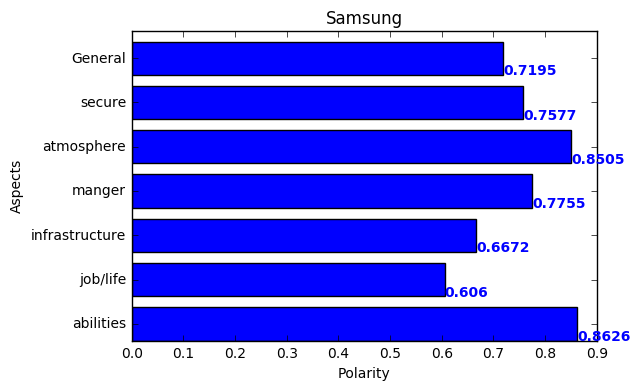

Overall Polarity  0.748423822726


In [82]:
print 'Aspect Classifier = Lexical'
aspect_polarity2,aspect_count2=naiveBayes_unigram(dataset[:1000],'lexical')
#with open('aspect_polarity1','w') as f:
#    json.dump(aspect_polarity1,f) 
#with open('aspect_count1','w') as f:
#    json.dump(aspect_count1,f)
result(aspect_polarity2 , aspect_count2,'Samsung')

# SVC Unigram

Aspect Classifier = Lexical
 
sentence : maintained customer database developed new clients maintained company performance standards evaluated market information researched new trends identified sales initiatives created strategies increase sales
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1

aspect_polarity =Counter({'Aspect7': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 1})
---------------------------
 
sentence : responded customer inquiries
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 2})
---------------------------
 
sentence : variety chances employees get promotion besides benefit package quite good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect2': array([ 3.]), 'Aspect7': array([ 2.]), 'Aspect1': array([ 1.])})
 
aspect_count =Counter({'Aspect2': 3, 'Aspect7': 2, 'Aspect1': 1})
---------------------------
 
sentence : fact normal staffs work overtime every week
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect2': array([ 3.]), 'Aspect7': array([ 2.]), 'Aspect4': array([ 1.]), 'Aspect3': array([ 1.]), 'Aspect1': array([ 1.])})
 
aspect_count =Counter({'Aspect2': 3, 'Aspect7': 2, 'Aspect4': 1, 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect4': array([ 3.]), 'Aspect2': array([ 3.]), 'Aspect7': array([ 2.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect4': 3, 'Aspect2': 3, 'Aspect7': 2, 'Aspect1': 2, 'Aspect3': 1})
---------------------------
 
sentence : every smile everybody friendly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect4': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect7': array([ 2.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect4': 4, 'Aspect2': 3, 'Aspect7': 2, 'Aspect1': 2, 'Aspect3': 1})
---------------------------
 
sentence : reason freely ask supporting
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect4': array([ 5.]), 'Aspect2': array([ 3.]), 'Aspect7': array([ 2.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect4': 5, 'Aspect2': 3, 'Aspect7': 2, 'Aspect1': 2, 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect4': array([ 5.]), 'Aspect7': array([ 3.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect4': 5, 'Aspect7': 3, 'Aspect2': 3, 'Aspect1': 2, 'Aspect3': 1})
---------------------------
 
sentence : job easy half people see
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect4': array([ 5.]), 'Aspect7': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect4': 5, 'Aspect7': 4, 'Aspect2': 3, 'Aspect1': 2, 'Aspect3': 1})
---------------------------
 
sentence : still sale
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 5.]), 'Aspect4': array([ 5.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 2.]), 'Aspect3': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 5, 'Aspect4': 5, 'Aspect2': 3, 'Aspect1': 2, 'Aspect3': 1})
---------------------------
 
senten

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 6.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.]), 'Aspect1': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 6, 'Aspect4': 6, 'Aspect2': 3, 'Aspect3': 2, 'Aspect1': 2})
---------------------------
 
sentence : also get target
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 7.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.]), 'Aspect1': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 7, 'Aspect4': 6, 'Aspect2': 3, 'Aspect3': 2, 'Aspect1': 2})
---------------------------
 
sentence : sale almost new phone stock days good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 8.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.]), 'Aspect1': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 8, 'Aspect4': 6, 'Aspect2': 3, 'Aspect3': 2, 'Aspect1': 2})
------------------

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([10.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 10, 'Aspect4': 6, 'Aspect2': 3, 'Aspect1': 3, 'Aspect3': 2})
---------------------------
 
sentence : heart warming upon completion appointments
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 11.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 11, 'Aspect4': 6, 'Aspect2': 3, 'Aspect1': 3, 'Aspect3': 2})
---------------------------
 
sentence : worked nights minimal supervision
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 12.]), 'Aspect4': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect1': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 12, 'Aspect4': 6, 'Aspect2': 3, 'Aspect1': 3, 'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 13.]), 'Aspect4': array([ 6.]), 'Aspect1': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 13, 'Aspect4': 6, 'Aspect1': 4, 'Aspect2': 3, 'Aspect3': 2})
---------------------------
 
sentence : technicians without seniority got cut
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 14.]), 'Aspect4': array([ 6.]), 'Aspect1': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 14, 'Aspect4': 6, 'Aspect1': 4, 'Aspect2': 3, 'Aspect3': 2})
---------------------------
 
sentence : respect employees
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 15.]), 'Aspect4': array([ 6.]), 'Aspect1': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 15, 'Aspect4': 6, 'Aspect1': 4, 'Aspect2': 3, 'Aspect3': 2})
----------

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 17.]), 'Aspect4': array([ 6.]), 'Aspect1': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 17, 'Aspect4': 6, 'Aspect1': 4, 'Aspect2': 3, 'Aspect3': 2, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : learned reduce work inherit half innovate problem solving
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 17.]), 'Aspect4': array([ 6.]), 'Aspect1': array([ 6.]), 'Aspect2': array([ 3.]), 'Aspect3': array([ 2.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 17, 'Aspect4': 6, 'Aspect1': 6, 'Aspect2': 3, 'Aspect3': 2, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : time management
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 17.]), 'Aspect4': array([ 7.]), 'Aspect1'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 17.]), 'Aspect4': array([ 8.]), 'Aspect1': array([ 7.]), 'Aspect3': array([ 4.]), 'Aspect2': array([ 3.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 17, 'Aspect4': 8, 'Aspect1': 7, 'Aspect3': 4, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : hardest part job getting answers management process claims
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 17.]), 'Aspect4': array([ 8.]), 'Aspect1': array([ 7.]), 'Aspect3': array([ 5.]), 'Aspect2': array([ 3.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 17, 'Aspect4': 8, 'Aspect1': 7, 'Aspect3': 5, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : enjoyable part day completing task ahead time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 17.]), 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 18.]), 'Aspect4': array([10.]), 'Aspect1': array([ 8.]), 'Aspect3': array([ 5.]), 'Aspect2': array([ 3.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 18, 'Aspect4': 10, 'Aspect1': 8, 'Aspect3': 5, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : questions fullest order truly solve problems
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 19.]), 'Aspect4': array([10.]), 'Aspect1': array([ 8.]), 'Aspect3': array([ 5.]), 'Aspect2': array([ 3.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 19, 'Aspect4': 10, 'Aspect1': 8, 'Aspect3': 5, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : co workers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 20.]), 'Aspect4': array([10.]), 'Aspect1': array([ 8.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 21.]), 'Aspect4': array([10.]), 'Aspect1': array([ 8.]), 'Aspect3': array([ 7.]), 'Aspect2': array([ 3.]), 'Aspect6': array([ 1.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 21, 'Aspect4': 10, 'Aspect1': 8, 'Aspect3': 7, 'Aspect2': 3, 'Aspect6': 1, 'Aspect5': 1})
---------------------------
 
sentence : management encourage creativity
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 21.]), 'Aspect4': array([10.]), 'Aspect3': array([ 8.]), 'Aspect1': array([ 8.]), 'Aspect6': array([ 3.]), 'Aspect2': array([ 3.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 21, 'Aspect4': 10, 'Aspect3': 8, 'Aspect1': 8, 'Aspect6': 3, 'Aspect2': 3, 'Aspect5': 1})
---------------------------
 
sentence : resource limit creative
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 21.]), 'Aspect4': array([10.]), 'Aspect3': array([ 8.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 22.]), 'Aspect4': array([ 11.]), 'Aspect3': array([ 8.]), 'Aspect1': array([ 8.]), 'Aspect6': array([ 4.]), 'Aspect2': array([ 4.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 22, 'Aspect4': 11, 'Aspect3': 8, 'Aspect1': 8, 'Aspect6': 4, 'Aspect2': 4, 'Aspect5': 1})
---------------------------
 
sentence : willing work shifting hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 22.]), 'Aspect4': array([ 12.]), 'Aspect3': array([ 8.]), 'Aspect1': array([ 8.]), 'Aspect6': array([ 4.]), 'Aspect2': array([ 4.]), 'Aspect5': array([ 1.])})
 
aspect_count =Counter({'Aspect7': 22, 'Aspect4': 12, 'Aspect3': 8, 'Aspect1': 8, 'Aspect6': 4, 'Aspect2': 4, 'Aspect5': 1})
---------------------------
 
sentence : learned lot sales
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 22.]), 'Aspect4': array([ 12.]), 'Aspect1': array([ 9.]), 'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 23.]), 'Aspect4': array([ 12.]), 'Aspect1': array([10.]), 'Aspect3': array([ 9.]), 'Aspect6': array([ 5.]), 'Aspect2': array([ 4.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 23, 'Aspect4': 12, 'Aspect1': 10, 'Aspect3': 9, 'Aspect6': 5, 'Aspect2': 4, 'Aspect5': 2})
---------------------------
 
sentence : boost worker
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 24.]), 'Aspect4': array([ 12.]), 'Aspect1': array([10.]), 'Aspect3': array([ 9.]), 'Aspect6': array([ 5.]), 'Aspect2': array([ 4.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 24, 'Aspect4': 12, 'Aspect1': 10, 'Aspect3': 9, 'Aspect6': 5, 'Aspect2': 4, 'Aspect5': 2})
---------------------------
 
sentence : hardest part job extend long hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 25.]), 'Aspect4': array([ 12.]), 'Aspect1': array([10.]), 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 26.]), 'Aspect4': array([ 13.]), 'Aspect1': array([10.]), 'Aspect3': array([ 9.]), 'Aspect6': array([ 5.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 26, 'Aspect4': 13, 'Aspect1': 10, 'Aspect3': 9, 'Aspect6': 5, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : great management great culture fun place work co workers make feel apart team get play cool products
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 26.]), 'Aspect4': array([ 13.]), 'Aspect3': array([10.]), 'Aspect1': array([10.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 26, 'Aspect4': 13, 'Aspect3': 10, 'Aspect1': 10, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : test drive
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': arra

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 27.]), 'Aspect4': array([ 13.]), 'Aspect1': array([ 11.]), 'Aspect3': array([10.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 27, 'Aspect4': 13, 'Aspect1': 11, 'Aspect3': 10, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : enjoyable work days fun amp
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 27.]), 'Aspect4': array([ 14.]), 'Aspect1': array([ 11.]), 'Aspect3': array([10.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 27, 'Aspect4': 14, 'Aspect1': 11, 'Aspect3': 10, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : friendly colleagues learned skills leader
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 27.]), 'Aspect4': array([ 16.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 12.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 27, 'Aspect4': 16, 'Aspect1': 13, 'Aspect3': 12, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : guide job
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 28.]), 'Aspect4': array([ 16.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 12.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 28, 'Aspect4': 16, 'Aspect1': 13, 'Aspect3': 12, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : joining pipe using apply safety first perform related duties required must able pass qualification test become friendly others respect supervisor hard work place free work place
Class= [1]


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 28.]), 'Aspect4': array([ 17.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 13.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 28, 'Aspect4': 17, 'Aspect3': 13, 'Aspect1': 13, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : large multi divisional corporation normal positives
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 29.]), 'Aspect4': array([ 17.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 13.]), 'Aspect6': array([ 6.]), 'Aspect2': array([ 5.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 29, 'Aspect4': 17, 'Aspect3': 13, 'Aspect1': 13, 'Aspect6': 6, 'Aspect2': 5, 'Aspect5': 2})
---------------------------
 
sentence : negatives large company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 30.]), 'Aspect4': array([ 1

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
aspect_polarity =Counter({'Aspect7': array([ 32.]), 'Aspect4': array([ 17.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 32, 'Aspect4': 17, 'Aspect3': 13, 'Aspect1': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : unfortunately slows reaction market changes
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 33.]), 'Aspect4': array([ 17.]), 'Aspect1': array([ 13.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 33, 'Aspect4': 17, 'Aspect3': 13, 'Aspect1': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : company learn handle different electronic device appliance specs advantages product product
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_po

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 34.]), 'Aspect4': array([ 17.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 34, 'Aspect4': 17, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : working man group going help making computers ready first time use since time made deal best buy employees stores help customers issues customers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([ 34.]), 'Aspect4': array([ 19.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 34, 'Aspect4': 19, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : would update computers programs needed one started would ready go
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 35.]), 'Aspect4': array([ 19.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 35, 'Aspect4': 19, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : trouble shoot tablets phones laptops
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 37.]), 'Aspect4': array([ 19.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 37, 'Aspect4': 19, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : enjoyed first time put thought project
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 37.]), 'Aspect4': array([ 21.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 37, 'Aspect4': 21, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : selves figured hours would work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 38.]), 'Aspect4': array([ 21.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 40.]), 'Aspect4': array([ 21.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 40, 'Aspect4': 21, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : get little time family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 40.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 40, 'Aspect4': 22, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : process oriented
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 41.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 43.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 43, 'Aspect4': 22, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : pleasure working finest people world
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 44.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 44, 'Aspect4': 22, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : sold top boxes
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 45.]), 'Aspect4': array([ 22.]), 'Aspect1': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 48.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 48, 'Aspect4': 22, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : represent globally
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 49.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 13.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 49, 'Aspect4': 22, 'Aspect1': 14, 'Aspect3': 13, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : l managers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 49.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 53.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 14.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 53, 'Aspect4': 22, 'Aspect3': 14, 'Aspect1': 14, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : made good friends many countries
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 54.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 14.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 54, 'Aspect4': 22, 'Aspect3': 14, 'Aspect1': 14, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : people came contact best part job
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 55.]), 'Aspect4': array([ 22.]), 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


aspect_count =Counter({'Aspect7': 57, 'Aspect4': 22, 'Aspect3': 14, 'Aspect1': 14, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : felt would impact customers negative way
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 58.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 14.]), 'Aspect2': array([ 7.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 58, 'Aspect4': 22, 'Aspect3': 14, 'Aspect1': 14, 'Aspect2': 7, 'Aspect6': 6, 'Aspect5': 2})
---------------------------
 
sentence : low salary need coordinate
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 58.]), 'Aspect4': array([ 22.]), 'Aspect1': array([ 14.]), 'Aspect3': array([ 14.]), 'Aspect2': array([ 8.]), 'Aspect6': array([ 6.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 58, 'Aspect4': 22, 'Aspect3': 14, 'Aspect1': 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 59.]), 'Aspect4': array([ 22.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect2': array([ 8.]), 'Aspect6': array([ 7.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 59, 'Aspect4': 22, 'Aspect3': 15, 'Aspect1': 14, 'Aspect2': 8, 'Aspect6': 7, 'Aspect5': 2})
---------------------------
 
sentence : hit target completion
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 60.]), 'Aspect4': array([ 22.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect2': array([ 8.]), 'Aspect6': array([ 7.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 60, 'Aspect4': 22, 'Aspect3': 15, 'Aspect1': 14, 'Aspect2': 8, 'Aspect6': 7, 'Aspect5': 2})
---------------------------
 
sentence : enjoyable part submission
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 60.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 15.

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 62.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect6': array([ 8.]), 'Aspect2': array([ 8.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 62, 'Aspect4': 23, 'Aspect3': 15, 'Aspect1': 14, 'Aspect6': 8, 'Aspect2': 8, 'Aspect5': 2})
---------------------------
 
sentence : high suicide rate especially
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 63.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect6': array([ 8.]), 'Aspect2': array([ 8.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 63, 'Aspect4': 23, 'Aspect3': 15, 'Aspect1': 14, 'Aspect6': 8, 'Aspect2': 8, 'Aspect5': 2})
---------------------------
 
sentence : front desk officer many years
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 64.]), 'Aspect4': array([ 23.]), 'Aspect3': 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 67.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect6': array([ 8.]), 'Aspect2': array([ 8.]), 'Aspect5': array([ 2.])})
 
aspect_count =Counter({'Aspect7': 67, 'Aspect4': 23, 'Aspect3': 15, 'Aspect1': 14, 'Aspect6': 8, 'Aspect2': 8, 'Aspect5': 2})
---------------------------
 
sentence : job consisted great communication customers order fit products fit lifestyles
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 67.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 15.]), 'Aspect1': array([ 14.]), 'Aspect6': array([ 8.]), 'Aspect2': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 67, 'Aspect4': 23, 'Aspect3': 15, 'Aspect1': 14, 'Aspect6': 8, 'Aspect2': 8, 'Aspect5': 3})
---------------------------
 
sentence : typical day would consist making sells light troubleshooting devices inventory checks
Class= [1]
Polarity = [ 1.]
final p

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 69.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 18.]), 'Aspect1': array([ 15.]), 'Aspect2': array([ 9.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 69, 'Aspect4': 23, 'Aspect3': 18, 'Aspect1': 15, 'Aspect2': 9, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : constant action plans fits company future goals
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 69.]), 'Aspect4': array([ 23.]), 'Aspect3': array([ 18.]), 'Aspect1': array([ 16.]), 'Aspect2': array([ 9.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 69, 'Aspect4': 23, 'Aspect3': 18, 'Aspect1': 16, 'Aspect2': 9, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : benefits overtime
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 69.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 18.]), 'Aspect1': array([ 16.]), 'Aspect2': array([10.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 69, 'Aspect4': 24, 'Aspect3': 18, 'Aspect1': 16, 'Aspect2': 10, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : work balance
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 70.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 18.]), 'Aspect1': array([ 16.]), 'Aspect2': array([10.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 70, 'Aspect4': 24, 'Aspect3': 18, 'Aspect1': 16, 'Aspect2': 10, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : managers bad
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 70.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': array

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 72.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': array([ 16.]), 'Aspect2': array([ 12.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 72, 'Aspect4': 24, 'Aspect3': 19, 'Aspect1': 16, 'Aspect2': 12, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : amazing team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 73.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': array([ 16.]), 'Aspect2': array([ 12.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 73, 'Aspect4': 24, 'Aspect3': 19, 'Aspect1': 16, 'Aspect2': 12, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : superb benefits
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 73.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 75.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 13.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 75, 'Aspect4': 24, 'Aspect3': 19, 'Aspect1': 18, 'Aspect2': 13, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : start answering important ones
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 76.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 19.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 13.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 76, 'Aspect4': 24, 'Aspect3': 19, 'Aspect1': 18, 'Aspect2': 13, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : day would several conference calls meetings departments managers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 76.

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 78.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 20.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 13.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 78, 'Aspect4': 24, 'Aspect3': 20, 'Aspect1': 18, 'Aspect2': 13, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : relied improve sales company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 79.]), 'Aspect4': array([ 24.]), 'Aspect3': array([ 20.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 13.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 79, 'Aspect4': 24, 'Aspect3': 20, 'Aspect1': 18, 'Aspect2': 13, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : come plans marketing
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 80.]), 'Aspect4': array([ 24.]), 'Aspect3': array

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 82.]), 'Aspect4': array([ 25.]), 'Aspect3': array([ 20.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 14.]), 'Aspect6': array([ 8.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 82, 'Aspect4': 25, 'Aspect3': 20, 'Aspect1': 18, 'Aspect2': 14, 'Aspect6': 8, 'Aspect5': 3})
---------------------------
 
sentence : great experience
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 82.]), 'Aspect4': array([ 25.]), 'Aspect3': array([ 20.]), 'Aspect1': array([ 18.]), 'Aspect2': array([ 14.]), 'Aspect6': array([ 9.]), 'Aspect5': array([ 3.])})
 
aspect_count =Counter({'Aspect7': 82, 'Aspect4': 25, 'Aspect3': 20, 'Aspect1': 18, 'Aspect2': 14, 'Aspect6': 9, 'Aspect5': 3})
---------------------------
 
sentence : learned lot things like communicate others
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 82.]), 'Aspect4': array([ 25.]), 'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 84.]), 'Aspect4': array([ 25.]), 'Aspect3': array([ 20.]), 'Aspect1': array([ 19.]), 'Aspect2': array([ 14.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 84, 'Aspect4': 25, 'Aspect3': 20, 'Aspect1': 19, 'Aspect2': 14, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : management personnel always provided great input promote safety
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 84.]), 'Aspect4': array([ 25.]), 'Aspect3': array([ 21.]), 'Aspect1': array([ 19.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 84, 'Aspect4': 25, 'Aspect3': 21, 'Aspect1': 19, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : productivity employees allowed environment cohesive regards
Class= [1]
Polarit

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 85.]), 'Aspect4': array([ 25.]), 'Aspect3': array([ 22.]), 'Aspect1': array([ 21.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 85, 'Aspect4': 25, 'Aspect3': 22, 'Aspect1': 21, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : busy season however overtime
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 85.]), 'Aspect4': array([ 26.]), 'Aspect3': array([ 22.]), 'Aspect1': array([ 21.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 85, 'Aspect4': 26, 'Aspect3': 22, 'Aspect1': 21, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : increase production sometimes weighed heavily wellbeing
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 86.]), 'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 87.]), 'Aspect4': array([ 27.]), 'Aspect3': array([ 22.]), 'Aspect1': array([ 21.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 87, 'Aspect4': 27, 'Aspect3': 22, 'Aspect1': 21, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : regional customers answer questions resolve issues
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 88.]), 'Aspect4': array([ 27.]), 'Aspect3': array([ 22.]), 'Aspect1': array([ 21.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 88, 'Aspect4': 27, 'Aspect3': 22, 'Aspect1': 21, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : full fun
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 89.]), 'Aspect4': array([ 27.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 90.]), 'Aspect4': array([ 27.]), 'Aspect1': array([ 22.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 90, 'Aspect4': 27, 'Aspect3': 22, 'Aspect1': 22, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : lots deal
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 91.]), 'Aspect4': array([ 27.]), 'Aspect1': array([ 22.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([10.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 91, 'Aspect4': 27, 'Aspect3': 22, 'Aspect1': 22, 'Aspect2': 15, 'Aspect6': 10, 'Aspect5': 4})
---------------------------
 
sentence : change distributors
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 92.]), 'Aspect4': array([ 27.]), 'Aspect1': array([ 22.]), 'Aspect3

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 94.]), 'Aspect4': array([ 28.]), 'Aspect1': array([ 24.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 94, 'Aspect4': 28, 'Aspect1': 24, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : favorite aspect job main duty engage customers meaningful conversation
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 95.]), 'Aspect4': array([ 28.]), 'Aspect1': array([ 24.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 95, 'Aspect4': 28, 'Aspect1': 24, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : grabbing attention next step introduce possible consumer products tables
Class= 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 96.]), 'Aspect4': array([ 28.]), 'Aspect1': array([ 24.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 96, 'Aspect4': 28, 'Aspect1': 24, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : thankfully job based commission takes pressure employee
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 97.]), 'Aspect4': array([ 28.]), 'Aspect1': array([ 24.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 97, 'Aspect4': 28, 'Aspect1': 24, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : stress free detail would transfer guest
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 97.]), 'Aspect4': array([ 29.]), 'Aspect1': array([ 26.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 97, 'Aspect4': 29, 'Aspect1': 26, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : even really bad long patient
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 98.]), 'Aspect4': array([ 29.]), 'Aspect1': array([ 26.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 11.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 98, 'Aspect4': 29, 'Aspect1': 26, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 11, 'Aspect5': 4})
---------------------------
 
sentence : afterwards customers usually extremely grateful help
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 99.]), 'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([100.]), 'Aspect4': array([ 29.]), 'Aspect1': array([ 27.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 100, 'Aspect4': 29, 'Aspect1': 27, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : gave lot confidence
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([100.]), 'Aspect4': array([ 29.]), 'Aspect1': array([ 28.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 100, 'Aspect4': 29, 'Aspect1': 28, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : job g training
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([100.]), 'Aspect1': array([ 29.]), 'Aspect4': array([ 29.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 101.]), 'Aspect1': array([ 31.]), 'Aspect4': array([ 31.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 101, 'Aspect4': 31, 'Aspect1': 31, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : maintain commitments employees
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 102.]), 'Aspect1': array([ 31.]), 'Aspect4': array([ 31.]), 'Aspect3': array([ 22.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 102, 'Aspect4': 31, 'Aspect1': 31, 'Aspect3': 22, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : poor project management
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 102.]), 'Aspect1': array([ 31.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 103.]), 'Aspect1': array([ 32.]), 'Aspect4': array([ 32.]), 'Aspect3': array([ 24.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 103, 'Aspect4': 32, 'Aspect1': 32, 'Aspect3': 24, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : good management
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 103.]), 'Aspect1': array([ 32.]), 'Aspect4': array([ 32.]), 'Aspect3': array([ 25.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 103, 'Aspect4': 32, 'Aspect1': 32, 'Aspect3': 25, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : work load high
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 104.]), 'Aspect1': array([ 32.]), 'Aspect4': array([ 32.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 107.]), 'Aspect4': array([ 34.]), 'Aspect1': array([ 33.]), 'Aspect3': array([ 25.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 107, 'Aspect4': 34, 'Aspect1': 33, 'Aspect3': 25, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : intelligent people
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 108.]), 'Aspect4': array([ 34.]), 'Aspect1': array([ 33.]), 'Aspect3': array([ 25.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 108, 'Aspect4': 34, 'Aspect1': 33, 'Aspect3': 25, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : relationships made
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 109.]), 'Aspect4': array([ 34.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 110.]), 'Aspect1': array([ 34.]), 'Aspect4': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 110, 'Aspect4': 34, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : free lunch
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 111.]), 'Aspect1': array([ 34.]), 'Aspect4': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 15.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 111, 'Aspect4': 34, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 15, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : good health benefit
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 111.]), 'Aspect1': array([ 34.]), 'Aspect4': array([ 34.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 115.]), 'Aspect1': array([ 34.]), 'Aspect4': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 16.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 115, 'Aspect4': 34, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 16, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : get little time family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 115.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 16.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 115, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 16, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : process oriented
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 116.]), 'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 118.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 118, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : sop changes regularly quotas completely unreasonable
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 119.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 26.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 119, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 26, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : management treat like child
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 119.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 122.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 27.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 4.])})
 
aspect_count =Counter({'Aspect7': 122, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 27, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 4})
---------------------------
 
sentence : organizing filing system answer telephones
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 122.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 27.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 5.])})
 
aspect_count =Counter({'Aspect7': 122, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 27, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 5})
---------------------------
 
sentence : transferred calls appropriate staff members interacted organizational staff executive clients

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 122.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 31.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 5.])})
 
aspect_count =Counter({'Aspect7': 122, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 31, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 5})
---------------------------
 
sentence : visitors daily basis organized scheduling meetings conference
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 123.]), 'Aspect4': array([ 35.]), 'Aspect1': array([ 34.]), 'Aspect3': array([ 31.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 5.])})
 
aspect_count =Counter({'Aspect7': 123, 'Aspect4': 35, 'Aspect1': 34, 'Aspect3': 31, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 5})
---------------------------
 
sentence : distributed minutes created spreadsheets
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 125.]), 'Aspect1': array([ 36.]), 'Aspect4': array([ 35.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 6.])})
 
aspect_count =Counter({'Aspect7': 125, 'Aspect1': 36, 'Aspect4': 35, 'Aspect3': 32, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 6})
---------------------------
 
sentence : committed grow organization high met lots lucky draws
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 125.]), 'Aspect1': array([ 37.]), 'Aspect4': array([ 35.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 6.])})
 
aspect_count =Counter({'Aspect7': 125, 'Aspect1': 37, 'Aspect4': 35, 'Aspect3': 32, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 6})
---------------------------
 
sentence : employ discount electronics
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarit

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 126.]), 'Aspect1': array([ 38.]), 'Aspect4': array([ 35.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 6.])})
 
aspect_count =Counter({'Aspect7': 126, 'Aspect1': 38, 'Aspect4': 35, 'Aspect3': 32, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 6})
---------------------------
 
sentence : normally change second
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 127.]), 'Aspect1': array([ 38.]), 'Aspect4': array([ 35.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 6.])})
 
aspect_count =Counter({'Aspect7': 127, 'Aspect1': 38, 'Aspect4': 35, 'Aspect3': 32, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 6})
---------------------------
 
sentence : receive really good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 128.]), 'Aspect1': array([ 38.]), 'Aspect4': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 129.]), 'Aspect1': array([ 40.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 17.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 7.])})
 
aspect_count =Counter({'Aspect7': 129, 'Aspect1': 40, 'Aspect4': 36, 'Aspect3': 32, 'Aspect2': 17, 'Aspect6': 12, 'Aspect5': 7})
---------------------------
 
sentence : office security
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 129.]), 'Aspect1': array([ 40.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 32.]), 'Aspect2': array([ 18.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 7.])})
 
aspect_count =Counter({'Aspect7': 129, 'Aspect1': 40, 'Aspect4': 36, 'Aspect3': 32, 'Aspect2': 18, 'Aspect6': 12, 'Aspect5': 7})
---------------------------
 
sentence : combined latest p
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 130.]), 'Aspect1': array([ 40.]), 'Aspect4': array([ 36.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


aspect_count =Counter({'Aspect7': 130, 'Aspect1': 41, 'Aspect4': 36, 'Aspect3': 33, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 7})
---------------------------
 
sentence : many solutions
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 131.]), 'Aspect1': array([ 41.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 33.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 7.])})
 
aspect_count =Counter({'Aspect7': 131, 'Aspect1': 41, 'Aspect4': 36, 'Aspect3': 33, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 7})
---------------------------
 
sentence : fully bee empowered company well member savant
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 131.]), 'Aspect1': array([ 41.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 34.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 7.])})
 
aspect_count =Counter({'Aspect7': 131, 'Aspect1': 41, 'Aspect4': 36, 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 132.]), 'Aspect1': array([ 42.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 34.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 132, 'Aspect1': 42, 'Aspect4': 36, 'Aspect3': 34, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 8})
---------------------------
 
sentence : ideas job good management far making team co workers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 132.]), 'Aspect1': array([ 42.]), 'Aspect4': array([ 36.]), 'Aspect3': array([ 35.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 132, 'Aspect1': 42, 'Aspect4': 36, 'Aspect3': 35, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 8})
---------------------------
 
sentence : hardest things part job cannot accomplish work day
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 133.]), 'Aspect1': array([ 42.]), 'Aspect4': array([ 37.]), 'Aspect3': array([ 35.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 133, 'Aspect1': 42, 'Aspect4': 37, 'Aspect3': 35, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 8})
---------------------------
 
sentence : working team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 134.]), 'Aspect1': array([ 42.]), 'Aspect4': array([ 37.]), 'Aspect3': array([ 35.]), 'Aspect2': array([ 19.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 134, 'Aspect1': 42, 'Aspect4': 37, 'Aspect3': 35, 'Aspect2': 19, 'Aspect6': 12, 'Aspect5': 8})
---------------------------
 
sentence : good medical benefits
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 134.]), 'Aspect1': array([ 42.]), 'Aspect4': array([ 37.

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 136.]), 'Aspect1': array([ 43.]), 'Aspect4': array([ 37.]), 'Aspect3': array([ 35.]), 'Aspect2': array([ 21.]), 'Aspect6': array([ 12.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 136, 'Aspect1': 43, 'Aspect4': 37, 'Aspect3': 35, 'Aspect2': 21, 'Aspect6': 12, 'Aspect5': 8})
---------------------------
 
sentence : engineers given lots responsibility quickly great learning experience however highly dependent department work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 136.]), 'Aspect1': array([ 44.]), 'Aspect4': array([ 37.]), 'Aspect3': array([ 35.]), 'Aspect2': array([ 21.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 8.])})
 
aspect_count =Counter({'Aspect7': 136, 'Aspect1': 44, 'Aspect4': 37, 'Aspect3': 35, 'Aspect2': 21, 'Aspect6': 13, 'Aspect5': 8})
---------------------------
 
sentence : work challenging
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_p

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 136.]), 'Aspect1': array([ 45.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 36.]), 'Aspect2': array([ 21.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 136, 'Aspect1': 45, 'Aspect4': 38, 'Aspect3': 36, 'Aspect2': 21, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : best part working people
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 137.]), 'Aspect1': array([ 45.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 36.]), 'Aspect2': array([ 21.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 137, 'Aspect1': 45, 'Aspect4': 38, 'Aspect3': 36, 'Aspect2': 21, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : good salary
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 137.]), 'Aspect1': array([ 45.]), 'Aspect4': array([ 3

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 139.]), 'Aspect1': array([ 46.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 36.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 139, 'Aspect1': 46, 'Aspect4': 38, 'Aspect3': 36, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : allows work employee high pressure
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 140.]), 'Aspect1': array([ 46.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 36.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 140, 'Aspect1': 46, 'Aspect4': 38, 'Aspect3': 36, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : always high target achieve set period
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 141.]), 'Aspect1':

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

sentence : one best work environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 143.]), 'Aspect1': array([ 46.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 37.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 143, 'Aspect1': 46, 'Aspect4': 38, 'Aspect3': 37, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : invest lots effort train employee
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 143.]), 'Aspect1': array([ 47.]), 'Aspect4': array([ 38.]), 'Aspect3': array([ 37.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 9.])})
 
aspect_count =Counter({'Aspect7': 143, 'Aspect1': 47, 'Aspect4': 38, 'Aspect3': 37, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 9})
---------------------------
 
sentence : learned risk management skills
Class= [1]
Polarity = [ 1.]
final 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 144.]), 'Aspect1': array([ 50.]), 'Aspect3': array([ 38.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([10.])})
 
aspect_count =Counter({'Aspect7': 144, 'Aspect1': 50, 'Aspect4': 38, 'Aspect3': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 10})
---------------------------
 
sentence : good mobility offerings phones tablets wearable
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 144.]), 'Aspect1': array([ 51.]), 'Aspect3': array([ 38.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([10.])})
 
aspect_count =Counter({'Aspect7': 144, 'Aspect1': 51, 'Aspect4': 38, 'Aspect3': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 10})
---------------------------
 
sentence : virtual reality
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Co

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 145.]), 'Aspect1': array([ 53.]), 'Aspect3': array([ 38.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([10.])})
 
aspect_count =Counter({'Aspect7': 145, 'Aspect1': 53, 'Aspect4': 38, 'Aspect3': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 10})
---------------------------
 
sentence : also management makes harder work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 145.]), 'Aspect1': array([ 53.]), 'Aspect3': array([ 39.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([10.])})
 
aspect_count =Counter({'Aspect7': 145, 'Aspect1': 53, 'Aspect3': 39, 'Aspect4': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 10})
---------------------------
 
sentence : transitioning work one best decisions made always date new technology cellphone
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Cou

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 146.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 39.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 146, 'Aspect1': 56, 'Aspect3': 39, 'Aspect4': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : management awesome work well schedule
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 146.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 40.]), 'Aspect4': array([ 38.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 146, 'Aspect1': 56, 'Aspect3': 40, 'Aspect4': 38, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : flexible hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 146.]), 'Aspect1': array([ 56.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 147.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 40.]), 'Aspect4': array([ 40.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 147, 'Aspect1': 56, 'Aspect4': 40, 'Aspect3': 40, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : operational plans
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 148.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 40.]), 'Aspect4': array([ 40.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 148, 'Aspect1': 56, 'Aspect4': 40, 'Aspect3': 40, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : strong marketing activities
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 149.]), 'Aspect1': array([ 56.]), 'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 151.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 42.]), 'Aspect4': array([ 42.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 151, 'Aspect1': 56, 'Aspect4': 42, 'Aspect3': 42, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : great company work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 152.]), 'Aspect1': array([ 56.]), 'Aspect3': array([ 42.]), 'Aspect4': array([ 42.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 152, 'Aspect1': 56, 'Aspect4': 42, 'Aspect3': 42, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : take time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 152.]), 'Aspect1': array([ 56.]), 'Aspect4': array([ 43.])

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 153.]), 'Aspect1': array([ 59.]), 'Aspect4': array([ 43.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 153, 'Aspect1': 59, 'Aspect4': 43, 'Aspect3': 42, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : need focused times
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 153.]), 'Aspect1': array([ 59.]), 'Aspect4': array([ 44.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 22.]), 'Aspect6': array([ 13.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 153, 'Aspect1': 59, 'Aspect4': 44, 'Aspect3': 42, 'Aspect2': 22, 'Aspect6': 13, 'Aspect5': 11})
---------------------------
 
sentence : working long hours quite common expected
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 154.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 154.]), 'Aspect1': array([ 62.]), 'Aspect4': array([ 44.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 23.]), 'Aspect6': array([ 15.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 154, 'Aspect1': 62, 'Aspect4': 44, 'Aspect3': 42, 'Aspect2': 23, 'Aspect6': 15, 'Aspect5': 11})
---------------------------
 
sentence : experience working people first language
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 154.]), 'Aspect1': array([ 62.]), 'Aspect4': array([ 44.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 23.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 154, 'Aspect1': 62, 'Aspect4': 44, 'Aspect3': 42, 'Aspect2': 23, 'Aspect6': 16, 'Aspect5': 11})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 155.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 158.]), 'Aspect1': array([ 62.]), 'Aspect4': array([ 45.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 23.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 158, 'Aspect1': 62, 'Aspect4': 45, 'Aspect3': 42, 'Aspect2': 23, 'Aspect6': 16, 'Aspect5': 11})
---------------------------
 
sentence : difficult place work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 159.]), 'Aspect1': array([ 62.]), 'Aspect4': array([ 45.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 23.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 159, 'Aspect1': 62, 'Aspect4': 45, 'Aspect3': 42, 'Aspect2': 23, 'Aspect6': 16, 'Aspect5': 11})
---------------------------
 
sentence : offer great benefits package however work life balance slim none
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 1

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 160.]), 'Aspect1': array([ 63.]), 'Aspect4': array([ 46.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 26.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 160, 'Aspect1': 63, 'Aspect4': 46, 'Aspect3': 42, 'Aspect2': 26, 'Aspect6': 16, 'Aspect5': 11})
---------------------------
 
sentence : great place work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 161.]), 'Aspect1': array([ 63.]), 'Aspect4': array([ 46.]), 'Aspect3': array([ 42.]), 'Aspect2': array([ 26.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 11.])})
 
aspect_count =Counter({'Aspect7': 161, 'Aspect1': 63, 'Aspect4': 46, 'Aspect3': 42, 'Aspect2': 26, 'Aspect6': 16, 'Aspect5': 11})
---------------------------
 
sentence : ability move within company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 161.]), 'Aspect1': array([ 64.]), 'Aspect4

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


sentence : good communication skill management good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 162.]), 'Aspect1': array([ 65.]), 'Aspect4': array([ 47.]), 'Aspect3': array([ 44.]), 'Aspect2': array([ 26.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 162, 'Aspect1': 65, 'Aspect4': 47, 'Aspect3': 44, 'Aspect2': 26, 'Aspect6': 16, 'Aspect5': 12})
---------------------------
 
sentence : make work load easy us
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 163.]), 'Aspect1': array([ 65.]), 'Aspect4': array([ 47.]), 'Aspect3': array([ 44.]), 'Aspect2': array([ 26.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 163, 'Aspect1': 65, 'Aspect4': 47, 'Aspect3': 44, 'Aspect2': 26, 'Aspect6': 16, 'Aspect5': 12})
---------------------------
 
sentence : benefit make workers ready work hardest part customers h

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 164.]), 'Aspect1': array([ 65.]), 'Aspect4': array([ 47.]), 'Aspect3': array([ 44.]), 'Aspect2': array([ 27.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 164, 'Aspect1': 65, 'Aspect4': 47, 'Aspect3': 44, 'Aspect2': 27, 'Aspect6': 16, 'Aspect5': 12})
---------------------------
 
sentence : easy make friends
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 165.]), 'Aspect1': array([ 65.]), 'Aspect4': array([ 47.]), 'Aspect3': array([ 44.]), 'Aspect2': array([ 27.]), 'Aspect6': array([ 16.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 165, 'Aspect1': 65, 'Aspect4': 47, 'Aspect3': 44, 'Aspect2': 27, 'Aspect6': 16, 'Aspect5': 12})
---------------------------
 
sentence : ready help asked enjoyable customers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 165.]), 'Aspect1': array([ 65.])

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 166.]), 'Aspect1': array([ 66.]), 'Aspect4': array([ 50.]), 'Aspect3': array([ 45.]), 'Aspect2': array([ 28.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 166, 'Aspect1': 66, 'Aspect4': 50, 'Aspect3': 45, 'Aspect2': 28, 'Aspect6': 18, 'Aspect5': 12})
---------------------------
 
sentence : like retail position
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 167.]), 'Aspect1': array([ 66.]), 'Aspect4': array([ 50.]), 'Aspect3': array([ 45.]), 'Aspect2': array([ 28.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 167, 'Aspect1': 66, 'Aspect4': 50, 'Aspect3': 45, 'Aspect2': 28, 'Aspect6': 18, 'Aspect5': 12})
---------------------------
 
sentence : lot expected compensated
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 167.]), 'Aspect1': array([ 66.]), 'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 170.]), 'Aspect1': array([ 66.]), 'Aspect4': array([ 50.]), 'Aspect3': array([ 45.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 170, 'Aspect1': 66, 'Aspect4': 50, 'Aspect3': 45, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 12})
---------------------------
 
sentence : give best type work learn much capability manage work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 170.]), 'Aspect1': array([ 67.]), 'Aspect4': array([ 50.]), 'Aspect3': array([ 46.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 12.])})
 
aspect_count =Counter({'Aspect7': 170, 'Aspect1': 67, 'Aspect4': 50, 'Aspect3': 46, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 12})
---------------------------
 
sentence : help co worker hardest job
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 171.])

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 171.]), 'Aspect1': array([ 67.]), 'Aspect4': array([ 51.]), 'Aspect3': array([ 46.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 13.])})
 
aspect_count =Counter({'Aspect7': 171, 'Aspect1': 67, 'Aspect4': 51, 'Aspect3': 46, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 13})
---------------------------
 
sentence : countless meetings unrelated work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 172.]), 'Aspect1': array([ 67.]), 'Aspect4': array([ 51.]), 'Aspect3': array([ 46.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 13.])})
 
aspect_count =Counter({'Aspect7': 172, 'Aspect1': 67, 'Aspect4': 51, 'Aspect3': 46, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 13})
---------------------------
 
sentence : typical day eat breakfast work check emails attending meeting go lunch check emails get coffee manager start 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 172.]), 'Aspect1': array([ 67.]), 'Aspect4': array([ 51.]), 'Aspect3': array([ 47.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 172, 'Aspect1': 67, 'Aspect4': 51, 'Aspect3': 47, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : available continue trying fix problem midnight take taxi home reimbursed
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 173.]), 'Aspect1': array([ 67.]), 'Aspect4': array([ 51.]), 'Aspect3': array([ 47.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 173, 'Aspect1': 67, 'Aspect4': 51, 'Aspect3': 47, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : attendance time staying touch team leader know news
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 174.]), 'Aspect1': array([ 69.]), 'Aspect4': array([ 52.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 174, 'Aspect1': 69, 'Aspect4': 52, 'Aspect3': 50, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : shifts long
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 174.]), 'Aspect1': array([ 69.]), 'Aspect4': array([ 53.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 30.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 174, 'Aspect1': 69, 'Aspect4': 53, 'Aspect3': 50, 'Aspect2': 30, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : advancements really happen
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 174.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 178.]), 'Aspect1': array([ 70.]), 'Aspect4': array([ 53.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 178, 'Aspect1': 70, 'Aspect4': 53, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : company learned everything especially using ms excel making file update time time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 178.]), 'Aspect1': array([ 71.]), 'Aspect4': array([ 55.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 18.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 178, 'Aspect1': 71, 'Aspect4': 55, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 18, 'Aspect5': 15})
---------------------------
 
sentence : time encourage
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 179.]), 'Aspect1': array([ 72.]), 'Aspect4': array([ 56.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 19.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 179, 'Aspect1': 72, 'Aspect4': 56, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 19, 'Aspect5': 15})
---------------------------
 
sentence : daily weekly tasks
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 180.]), 'Aspect1': array([ 72.]), 'Aspect4': array([ 56.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 19.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 180, 'Aspect1': 72, 'Aspect4': 56, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 19, 'Aspect5': 15})
---------------------------
 
sentence : proactive person always possibility acquire new skills
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 180.]), 'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 182.]), 'Aspect1': array([ 73.]), 'Aspect4': array([ 57.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 19.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 182, 'Aspect1': 73, 'Aspect4': 57, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 19, 'Aspect5': 15})
---------------------------
 
sentence : extra reports carry due continuous request coming
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 183.]), 'Aspect1': array([ 73.]), 'Aspect4': array([ 57.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 19.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 183, 'Aspect1': 73, 'Aspect4': 57, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 19, 'Aspect5': 15})
---------------------------
 
sentence : many visiting company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 184.]), 'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


---------------------------
 
sentence : outside workplace
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 186.]), 'Aspect1': array([ 73.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 50.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 186, 'Aspect1': 73, 'Aspect4': 58, 'Aspect3': 50, 'Aspect2': 32, 'Aspect6': 20, 'Aspect5': 15})
---------------------------
 
sentence : management n
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 186.]), 'Aspect1': array([ 73.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 51.]), 'Aspect2': array([ 32.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 186, 'Aspect1': 73, 'Aspect4': 58, 'Aspect3': 51, 'Aspect2': 32, 'Aspect6': 20, 'Aspect5': 15})
---------------------------
 
sentence : controlling remotely
Class= [1]
Polarity = [ 1.]
final pola

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 189.]), 'Aspect1': array([ 75.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 51.]), 'Aspect2': array([ 34.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 189, 'Aspect1': 75, 'Aspect4': 58, 'Aspect3': 51, 'Aspect2': 34, 'Aspect6': 20, 'Aspect5': 15})
---------------------------
 
sentence : good employer
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 189.]), 'Aspect1': array([ 76.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 51.]), 'Aspect2': array([ 34.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 15.])})
 
aspect_count =Counter({'Aspect7': 189, 'Aspect1': 76, 'Aspect4': 58, 'Aspect3': 51, 'Aspect2': 34, 'Aspect6': 20, 'Aspect5': 15})
---------------------------
 
sentence : need projects us
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 190.]), 'Aspect1': array([ 76.]), 'Aspect4': array([ 58.

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 192.]), 'Aspect1': array([ 78.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 51.]), 'Aspect2': array([ 34.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 192, 'Aspect1': 78, 'Aspect4': 58, 'Aspect3': 51, 'Aspect2': 34, 'Aspect6': 20, 'Aspect5': 16})
---------------------------
 
sentence : target oriented company ready work environment amp
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 193.]), 'Aspect1': array([ 78.]), 'Aspect4': array([ 58.]), 'Aspect3': array([ 51.]), 'Aspect2': array([ 34.]), 'Aspect6': array([ 20.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 193, 'Aspect1': 78, 'Aspect4': 58, 'Aspect3': 51, 'Aspect2': 34, 'Aspect6': 20, 'Aspect5': 16})
---------------------------
 
sentence : compensation good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counte

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 193.]), 'Aspect1': array([ 80.]), 'Aspect4': array([ 59.]), 'Aspect3': array([ 53.]), 'Aspect2': array([ 36.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 193, 'Aspect1': 80, 'Aspect4': 59, 'Aspect3': 53, 'Aspect2': 36, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : assess staff equally
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 193.]), 'Aspect1': array([ 80.]), 'Aspect4': array([ 59.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 36.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 193, 'Aspect1': 80, 'Aspect4': 59, 'Aspect3': 54, 'Aspect2': 36, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : learn conduct consumer training push sales operation check maintain cleanliness
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 193.]), 'Aspect1': array([ 84.]), 'Aspect4': array([ 60.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 36.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 193, 'Aspect1': 84, 'Aspect4': 60, 'Aspect3': 54, 'Aspect2': 36, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : started sprint vision deployment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 194.]), 'Aspect1': array([ 84.]), 'Aspect4': array([ 60.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 36.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 194, 'Aspect1': 84, 'Aspect4': 60, 'Aspect3': 54, 'Aspect2': 36, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : markets diagonally
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 197.]), 'Aspect1': array([ 84.]), 'Aspect4': array([ 60.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 197, 'Aspect1': 84, 'Aspect4': 60, 'Aspect3': 54, 'Aspect2': 37, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : learn work g based g network
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 197.]), 'Aspect1': array([ 85.]), 'Aspect4': array([ 60.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 21.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 197, 'Aspect1': 85, 'Aspect4': 60, 'Aspect3': 54, 'Aspect2': 37, 'Aspect6': 21, 'Aspect5': 16})
---------------------------
 
sentence : good deployment team support
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 197.]), 'Aspect1': array([ 85

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
aspect_count =Counter({'Aspect7': 198, 'Aspect1': 86, 'Aspect4': 61, 'Aspect3': 54, 'Aspect2': 37, 'Aspect6': 22, 'Aspect5': 16})
---------------------------
 
sentence : lots team work happens
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 199.]), 'Aspect1': array([ 86.]), 'Aspect4': array([ 61.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 22.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 199, 'Aspect1': 86, 'Aspect4': 61, 'Aspect3': 54, 'Aspect2': 37, 'Aspect6': 22, 'Aspect5': 16})
---------------------------
 
sentence : typical day starts challenging tasks
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 199.]), 'Aspect1': array([ 87.]), 'Aspect4': array([ 61.]), 'Aspect3': array([ 54.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 22.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 199, 'Aspect1': 87, 'Aspect4': 61, 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 201.]), 'Aspect1': array([ 87.]), 'Aspect4': array([ 61.]), 'Aspect3': array([ 55.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 23.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 201, 'Aspect1': 87, 'Aspect4': 61, 'Aspect3': 55, 'Aspect2': 37, 'Aspect6': 23, 'Aspect5': 16})
---------------------------
 
sentence : good company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 202.]), 'Aspect1': array([ 87.]), 'Aspect4': array([ 61.]), 'Aspect3': array([ 55.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 23.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 202, 'Aspect1': 87, 'Aspect4': 61, 'Aspect3': 55, 'Aspect2': 37, 'Aspect6': 23, 'Aspect5': 16})
---------------------------
 
sentence : good learning experience
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 202.]), 'Aspect1': array([ 88.]), 'Aspect4': arra

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 205.]), 'Aspect1': array([ 88.]), 'Aspect4': array([ 62.]), 'Aspect3': array([ 55.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 205, 'Aspect1': 88, 'Aspect4': 62, 'Aspect3': 55, 'Aspect2': 37, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : end result oriented
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 206.]), 'Aspect1': array([ 88.]), 'Aspect4': array([ 62.]), 'Aspect3': array([ 55.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 206, 'Aspect1': 88, 'Aspect4': 62, 'Aspect3': 55, 'Aspect2': 37, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : want results cost
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 207.]), '

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 208.]), 'Aspect1': array([ 88.]), 'Aspect4': array([ 62.]), 'Aspect3': array([ 57.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 208, 'Aspect1': 88, 'Aspect4': 62, 'Aspect3': 57, 'Aspect2': 37, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : days week work procurement learned multiple management
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 208.]), 'Aspect1': array([ 89.]), 'Aspect4': array([ 62.]), 'Aspect3': array([ 58.]), 'Aspect2': array([ 37.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 208, 'Aspect1': 89, 'Aspect4': 62, 'Aspect3': 58, 'Aspect2': 37, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : us many time work achievement hard maintain good pay
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_count =Counter({'Aspect7': 208, 'Aspect1': 89, 'Aspect4': 64, 'Aspect3': 59, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : team work highly discriminating work processes
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 209.]), 'Aspect1': array([ 89.]), 'Aspect4': array([ 64.]), 'Aspect3': array([ 59.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 209, 'Aspect1': 89, 'Aspect4': 64, 'Aspect3': 59, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : review past work many things learn life starting working
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 209.]), 'Aspect1': array([ 90.]), 'Aspect4': array([ 65.]), 'Aspect3': array([ 59.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 210.]), 'Aspect1': array([ 93.]), 'Aspect4': array([ 65.]), 'Aspect3': array([ 60.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 210, 'Aspect1': 93, 'Aspect4': 65, 'Aspect3': 60, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : typical day fun
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 211.]), 'Aspect1': array([ 93.]), 'Aspect4': array([ 65.]), 'Aspect3': array([ 60.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 211, 'Aspect1': 93, 'Aspect4': 65, 'Aspect3': 60, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : exciting co worker
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 213.]), 'Aspect1': array([ 93.]), 'Aspect4': array([ 68.]), 'Aspect3': array([ 60.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 213, 'Aspect1': 93, 'Aspect4': 68, 'Aspect3': 60, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : facilitate sales
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 214.]), 'Aspect1': array([ 93.]), 'Aspect4': array([ 68.]), 'Aspect3': array([ 60.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 214, 'Aspect1': 93, 'Aspect4': 68, 'Aspect3': 60, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : management reasonable
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 214.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 217.]), 'Aspect1': array([ 93.]), 'Aspect4': array([ 70.]), 'Aspect3': array([ 61.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 217, 'Aspect1': 93, 'Aspect4': 70, 'Aspect3': 61, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : learned lot things instrumentation
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 217.]), 'Aspect1': array([ 94.]), 'Aspect4': array([ 70.]), 'Aspect3': array([ 61.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 217, 'Aspect1': 94, 'Aspect4': 70, 'Aspect3': 61, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : management great love co workers treat hardest part work risk
Class= [1]
Polarity = [ 1.]
final p

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 217.]), 'Aspect1': array([ 94.]), 'Aspect4': array([ 73.]), 'Aspect3': array([ 62.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 217, 'Aspect1': 94, 'Aspect4': 73, 'Aspect3': 62, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : quality good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 218.]), 'Aspect1': array([ 94.]), 'Aspect4': array([ 73.]), 'Aspect3': array([ 62.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 25.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 218, 'Aspect1': 94, 'Aspect4': 73, 'Aspect3': 62, 'Aspect2': 38, 'Aspect6': 25, 'Aspect5': 16})
---------------------------
 
sentence : awful corporate culture extremely hierarchical
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 218.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 219.]), 'Aspect1': array([ 95.]), 'Aspect4': array([ 73.]), 'Aspect3': array([ 63.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 26.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 219, 'Aspect1': 95, 'Aspect4': 73, 'Aspect3': 63, 'Aspect2': 38, 'Aspect6': 26, 'Aspect5': 16})
---------------------------
 
sentence : working wonderful learning experience
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 219.]), 'Aspect1': array([ 96.]), 'Aspect4': array([ 73.]), 'Aspect3': array([ 63.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 16.])})
 
aspect_count =Counter({'Aspect7': 219, 'Aspect1': 96, 'Aspect4': 73, 'Aspect3': 63, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 16})
---------------------------
 
sentence : interacting customers regularly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 220.]), 'Aspect1'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 221.]), 'Aspect1': array([ 97.]), 'Aspect4': array([ 74.]), 'Aspect3': array([ 63.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 221, 'Aspect1': 97, 'Aspect4': 74, 'Aspect3': 63, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 17})
---------------------------
 
sentence : high business rhythm possibility test new ideas high level management co workers really best market lot stuff like report report enjoyable part job winner
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 221.]), 'Aspect1': array([ 97.]), 'Aspect4': array([ 75.]), 'Aspect3': array([ 64.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 221, 'Aspect1': 97, 'Aspect4': 75, 'Aspect3': 64, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 17})
---------------------------
 
sentence : really enjoyable work enjoyed lot working crew amazing gave lot support taught lot learned lot thing manpower handling time sheet making payslip etc
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 221.]), 'Aspect1': array([ 98.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 64.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 221, 'Aspect1': 98, 'Aspect4': 79, 'Aspect3': 64, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 17})
---------------------------
 
sentence : hardest part listen shout without 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 222.]), 'Aspect1': array([ 98.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 64.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 222, 'Aspect1': 98, 'Aspect4': 79, 'Aspect3': 64, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 17})
---------------------------
 
sentence : manager nice never sought reason taught lot
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 222.]), 'Aspect1': array([ 98.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 65.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 27.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 222, 'Aspect1': 98, 'Aspect4': 79, 'Aspect3': 65, 'Aspect2': 38, 'Aspect6': 27, 'Aspect5': 17})
---------------------------
 
sentence : designer lot work experience diverse mobile platforms
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
sentence : experienced deals various mobile platforms android
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 224.]), 'Aspect1': array([ 102.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 65.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 30.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 224, 'Aspect1': 102, 'Aspect4': 79, 'Aspect3': 65, 'Aspect2': 38, 'Aspect6': 30, 'Aspect5': 17})
---------------------------
 
sentence : web multiple platform strategy
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 224.]), 'Aspect1': array([ 103.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 65.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 31.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 224, 'Aspect1': 103, 'Aspect4': 79, 'Aspect3': 65, 'Aspect2': 38, 'Aspect6': 31, 'Aspect5': 17})
---------------------------
 
sentence : therefore many employees complet

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 226.]), 'Aspect1': array([ 104.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 65.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 32.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 226, 'Aspect1': 104, 'Aspect4': 79, 'Aspect3': 65, 'Aspect2': 38, 'Aspect6': 32, 'Aspect5': 17})
---------------------------
 
sentence : individual native speaking individual severely disadvantaged get go
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 227.]), 'Aspect1': array([ 104.]), 'Aspect4': array([ 79.]), 'Aspect3': array([ 65.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 32.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 227, 'Aspect1': 104, 'Aspect4': 79, 'Aspect3': 65, 'Aspect2': 38, 'Aspect6': 32, 'Aspect5': 17})
---------------------------
 
sentence : sense team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 228.

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 230.]), 'Aspect1': array([ 105.]), 'Aspect4': array([ 80.]), 'Aspect3': array([ 67.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 32.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 230, 'Aspect1': 105, 'Aspect4': 80, 'Aspect3': 67, 'Aspect2': 38, 'Aspect6': 32, 'Aspect5': 17})
---------------------------
 
sentence : care employee else training poor individuals thrown mix day
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 230.]), 'Aspect1': array([ 106.]), 'Aspect4': array([ 80.]), 'Aspect3': array([ 67.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 32.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 230, 'Aspect1': 106, 'Aspect4': 80, 'Aspect3': 67, 'Aspect2': 38, 'Aspect6': 32, 'Aspect5': 17})
---------------------------
 
sentence : expected fend sink swim
Class= [1]
Polarity = [ 1.]
final polarity=[

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 231.]), 'Aspect1': array([ 106.]), 'Aspect4': array([ 80.]), 'Aspect3': array([ 67.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 32.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 231, 'Aspect1': 106, 'Aspect4': 80, 'Aspect3': 67, 'Aspect2': 38, 'Aspect6': 32, 'Aspect5': 17})
---------------------------
 
sentence : culture one working hours per week weekends call times slacker
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 231.]), 'Aspect1': array([ 106.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 67.]), 'Aspect2': array([ 38.]), 'Aspect6': array([ 33.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 231, 'Aspect1': 106, 'Aspect4': 81, 'Aspect3': 67, 'Aspect2': 38, 'Aspect6': 33, 'Aspect5': 17})
---------------------------
 
sentence : receive poor reviews
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 232.]), 'Aspect1': array([ 106.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 68.]), 'Aspect2': array([ 39.]), 'Aspect6': array([ 34.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 232, 'Aspect1': 106, 'Aspect4': 81, 'Aspect3': 68, 'Aspect2': 39, 'Aspect6': 34, 'Aspect5': 17})
---------------------------
 
sentence : expects one conform
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 233.]), 'Aspect1': array([ 106.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 68.]), 'Aspect2': array([ 39.]), 'Aspect6': array([ 34.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 233, 'Aspect1': 106, 'Aspect4': 81, 'Aspect3': 68, 'Aspect2': 39, 'Aspect6': 34, 'Aspect5': 17})
---------------------------
 
sentence : management interested changing try
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


---------------------------
 
sentence : list goes
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 235.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 235, 'Aspect1': 107, 'Aspect4': 81, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------------
 
sentence : eventually philosophy never changing continuing exact path brought success years ago going bury
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 236.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 236, 'Aspect1': 107, 'Aspect4': 81, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
aspect_polarity =Counter({'Aspect7': array([ 238.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 238, 'Aspect1': 107, 'Aspect4': 81, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------------
 
sentence : work fast paced
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 239.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 81.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 239, 'Aspect1': 107, 'Aspect4': 81, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------------
 
sentence : mostly quality compromised saving time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 239.]), 'Aspect1': array(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
sentence : hours must need considered top performer
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 241.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 83.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 241, 'Aspect1': 107, 'Aspect4': 83, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------------
 
sentence : time hill contractors work together ensure smooth working work place
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 241.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 84.]), 'Aspect3': array([ 69.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 17.])})
 
aspect_count =Counter({'Aspect7': 241, 'Aspect1': 107, 'Aspect4': 84, 'Aspect3': 69, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 17})
---------------------------
 
sentence : mana

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


---------------------------
 
sentence : working gulf helped improve personally
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 242.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 85.]), 'Aspect3': array([ 70.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 242, 'Aspect1': 107, 'Aspect4': 85, 'Aspect3': 70, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 18})
---------------------------
 
sentence : typical day work starts greeting colleagues
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 243.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 85.]), 'Aspect3': array([ 70.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 243, 'Aspect1': 107, 'Aspect4': 85, 'Aspect3': 70, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 18})
---------------------------
 
sentence : peo

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 245.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 85.]), 'Aspect3': array([ 70.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 245, 'Aspect1': 107, 'Aspect4': 85, 'Aspect3': 70, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 18})
---------------------------
 
sentence : team building activities enjoyable part
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 245.]), 'Aspect1': array([ 107.]), 'Aspect4': array([ 86.]), 'Aspect3': array([ 70.]), 'Aspect2': array([ 40.]), 'Aspect6': array([ 35.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 245, 'Aspect1': 107, 'Aspect4': 86, 'Aspect3': 70, 'Aspect2': 40, 'Aspect6': 35, 'Aspect5': 18})
---------------------------
 
sentence : getting high incentives
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polari

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([ 245.]), 'Aspect1': array([ 109.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 71.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 36.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 245, 'Aspect1': 109, 'Aspect4': 87, 'Aspect3': 71, 'Aspect2': 42, 'Aspect6': 36, 'Aspect5': 18})
---------------------------
 
sentence : hr either turn around play blame game leadership anywhere side long gone fair amp considered soft amp buddy buddy good hard working truly work amp feed families vs fresh young talent party amp step anyone along way get top
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([ 245.]), 'Aspect1': array([ 110.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 72.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 36.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 245, 'Aspect1': 110, 'Aspect4': 87, 'Aspect3': 72, 'Aspect2': 42, 'Aspect6': 36, 'Aspect5': 18})
---------------------------
 
sentence : finish repair
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 246.]), 'Aspect1': array([ 110.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 72.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 36.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 246, 'Aspect1': 110, 'Aspect4': 87, 'Aspect3': 72, 'Aspect2': 42, 'Aspect6': 36, 'Aspect5': 18})
---------------------------
 
sentence : servicing electronic device nationwide learn repair printers projector also set interactive board
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 246.]), 'Aspect1': array([ 112.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 72.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 246, 'Aspect1': 112, 'Aspect4': 87, 'Aspect3': 72, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : fail translate really limiting since want record year end review remembered
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 247.]), 'Aspect1': array([ 112.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 72.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 247, 'Aspect1': 112, 'Aspect4': 87, 'Aspect3': 72, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : well company learned independent
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Co

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

sentence : fellow co workers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 248.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 74.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 248, 'Aspect1': 113, 'Aspect4': 87, 'Aspect3': 74, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : united worked hard keep customers happy
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 249.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 87.]), 'Aspect3': array([ 74.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 249, 'Aspect1': 113, 'Aspect4': 87, 'Aspect3': 74, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : enjoyable part job dealing angry customers
Class= [1]
Polar

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 251.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 88.]), 'Aspect3': array([ 74.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 251, 'Aspect1': 113, 'Aspect4': 88, 'Aspect3': 74, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : price tags items
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 252.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 88.]), 'Aspect3': array([ 74.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 37.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 252, 'Aspect1': 113, 'Aspect4': 88, 'Aspect3': 74, 'Aspect2': 42, 'Aspect6': 37, 'Aspect5': 18})
---------------------------
 
sentence : good customer service handle difficult customers work well group
Class= [1]
Polarity = [ 1.]
final polarity=[ 1

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 253.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 89.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 38.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 253, 'Aspect1': 113, 'Aspect4': 89, 'Aspect3': 75, 'Aspect2': 42, 'Aspect6': 38, 'Aspect5': 18})
---------------------------
 
sentence : bad days comes co workers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 254.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 89.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 38.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 254, 'Aspect1': 113, 'Aspect4': 89, 'Aspect3': 75, 'Aspect2': 42, 'Aspect6': 38, 'Aspect5': 18})
---------------------------
 
sentence : generally get along well
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 254.]), 'Aspect1': array([ 113.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 257.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 89.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 42.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 257, 'Aspect1': 113, 'Aspect4': 89, 'Aspect3': 75, 'Aspect2': 42, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : shops sales rewarding addition commission comes sales
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 257.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 89.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 43.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 257, 'Aspect1': 113, 'Aspect4': 89, 'Aspect3': 75, 'Aspect2': 43, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 258.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 260.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 90.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 43.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 260, 'Aspect1': 113, 'Aspect4': 90, 'Aspect3': 75, 'Aspect2': 43, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : want results cost
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 261.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 90.]), 'Aspect3': array([ 75.]), 'Aspect2': array([ 43.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 261, 'Aspect1': 113, 'Aspect4': 90, 'Aspect3': 75, 'Aspect2': 43, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : overall job
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 262.]), 'Aspect1': array([ 113.]), 'Aspect4': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 264.]), 'Aspect1': array([ 113.]), 'Aspect4': array([ 90.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 264, 'Aspect1': 113, 'Aspect4': 90, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : enjoyed working learned lot products
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 264.]), 'Aspect1': array([ 114.]), 'Aspect4': array([ 91.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 39.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 264, 'Aspect1': 114, 'Aspect4': 91, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 39, 'Aspect5': 18})
---------------------------
 
sentence : agree number electronic industry
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 266.]), 'Aspect1': array([ 114.]), 'Aspect4': array([ 93.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 41.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 266, 'Aspect1': 114, 'Aspect4': 93, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 41, 'Aspect5': 18})
---------------------------
 
sentence : need help financial support family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 266.]), 'Aspect1': array([ 114.]), 'Aspect4': array([ 94.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 41.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 266, 'Aspect1': 114, 'Aspect4': 94, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 41, 'Aspect5': 18})
---------------------------
 
sentence : many constant hours top
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 267.]), 'Aspect1': array

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 267.]), 'Aspect1': array([ 116.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 41.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 267, 'Aspect1': 116, 'Aspect4': 95, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 41, 'Aspect5': 18})
---------------------------
 
sentence : amazing work culture
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 267.]), 'Aspect1': array([ 116.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 76.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 42.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 267, 'Aspect1': 116, 'Aspect4': 95, 'Aspect3': 76, 'Aspect2': 44, 'Aspect6': 42, 'Aspect5': 18})
---------------------------
 
sentence : good experience
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 269.]), 'Aspect1': array([ 116.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 77.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 43.]), 'Aspect5': array([ 18.])})
 
aspect_count =Counter({'Aspect7': 269, 'Aspect1': 116, 'Aspect4': 95, 'Aspect3': 77, 'Aspect2': 44, 'Aspect6': 43, 'Aspect5': 18})
---------------------------
 
sentence : clear direction almost inter departmental communication
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 269.]), 'Aspect1': array([ 116.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 77.]), 'Aspect2': array([ 44.]), 'Aspect6': array([ 43.]), 'Aspect5': array([ 19.])})
 
aspect_count =Counter({'Aspect7': 269, 'Aspect1': 116, 'Aspect4': 95, 'Aspect3': 77, 'Aspect2': 44, 'Aspect6': 43, 'Aspect5': 19})
---------------------------
 
sentence : current management team absolutely one worst ever worked
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 269.]), 'Aspect1': array([ 118.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 44.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 19.])})
 
aspect_count =Counter({'Aspect7': 269, 'Aspect1': 118, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 44, 'Aspect2': 44, 'Aspect5': 19})
---------------------------
 
sentence : strive global impact developing tomorrow innovations enhance lives today
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 269.]), 'Aspect1': array([ 119.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 19.])})
 
aspect_count =Counter({'Aspect7': 269, 'Aspect1': 119, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 19})
---------------------------
 
sentence : monitor daily instrumentation activities
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarit

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 272.]), 'Aspect1': array([ 119.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 19.])})
 
aspect_count =Counter({'Aspect7': 272, 'Aspect1': 119, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 19})
---------------------------
 
sentence : provide solutions problems approvals though documentation control process non conforming items deficiencies unsatisfactory condition rectified
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 273.]), 'Aspect1': array([ 119.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 19.])})
 
aspect_count =Counter({'Aspect7': 273, 'Aspect1': 119, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 19})
---------------------------
 
sentence : remedial action resolution approved


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 274.]), 'Aspect1': array([ 119.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 274, 'Aspect1': 119, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : ensure given highest priority
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 275.]), 'Aspect1': array([ 119.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 78.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 275, 'Aspect1': 119, 'Aspect4': 95, 'Aspect3': 78, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : particularly personnel adequately trained execute work assignment safety training amp
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polar

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 276.]), 'Aspect1': array([ 121.]), 'Aspect4': array([ 95.]), 'Aspect3': array([ 79.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 276, 'Aspect1': 121, 'Aspect4': 95, 'Aspect3': 79, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : identify potential hazards times
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 276.]), 'Aspect1': array([ 121.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 79.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 276, 'Aspect1': 121, 'Aspect4': 96, 'Aspect3': 79, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : responsible clearing
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 277.]), 'Aspect1': array([ 12

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 280.]), 'Aspect1': array([ 121.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 79.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 280, 'Aspect1': 121, 'Aspect4': 96, 'Aspect3': 79, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : new people talking many different customers also store staff well teach new products
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 280.]), 'Aspect1': array([ 122.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 44.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 280, 'Aspect1': 122, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 45, 'Aspect2': 44, 'Aspect5': 20})
---------------------------
 
sentence : lesson needed
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 281.]), 'Aspect1': array([ 122.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 281, 'Aspect1': 122, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 45, 'Aspect2': 45, 'Aspect5': 20})
---------------------------
 
sentence : trainings offered monthly employees improvement
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 281.]), 'Aspect1': array([ 123.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 281, 'Aspect1': 123, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 45, 'Aspect2': 45, 'Aspect5': 20})
---------------------------
 
sentence : nice workplace
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 282.]), 'Aspect1': a

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 284.]), 'Aspect1': array([ 123.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 284, 'Aspect1': 123, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 45, 'Aspect2': 45, 'Aspect5': 20})
---------------------------
 
sentence : highly innovative products
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 284.]), 'Aspect1': array([ 124.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 45.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 20.])})
 
aspect_count =Counter({'Aspect7': 284, 'Aspect1': 124, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 45, 'Aspect2': 45, 'Aspect5': 20})
---------------------------
 
sentence : driven forward thinking culture individuals
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 284.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 284.]), 'Aspect1': array([ 125.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 284, 'Aspect1': 125, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : unique partners
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 285.]), 'Aspect1': array([ 125.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 285, 'Aspect1': 125, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : excellent people skills
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 285.]), 'Aspect1': array([ 126.]), 'Aspect4

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 287.]), 'Aspect1': array([ 127.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 287, 'Aspect1': 127, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : change direction
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 288.]), 'Aspect1': array([ 127.]), 'Aspect4': array([ 96.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 288, 'Aspect1': 127, 'Aspect4': 96, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : must willing agile
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 289.]), 'Aspect1': array([ 127.]), 'Aspect4': a

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 290.]), 'Aspect1': array([ 128.]), 'Aspect4': array([ 97.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 290, 'Aspect1': 128, 'Aspect4': 97, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : also solutions layer hardware truly bring life
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 290.]), 'Aspect1': array([ 128.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 290, 'Aspect1': 128, 'Aspect4': 98, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : keeping work neat
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 291.]), 'Aspect1':

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 292.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 292, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : comprises divisions subsidiaries across represent circa
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 293.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 80.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 293, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 80, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : recently become leading consumer electronics b
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 295.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 82.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 295, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 82, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : double turnover
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 296.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 82.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 45.]), 'Aspect5': array([ 21.])})
 
aspect_count =Counter({'Aspect7': 296, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 82, 'Aspect6': 46, 'Aspect2': 45, 'Aspect5': 21})
---------------------------
 
sentence : hours long
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 297.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 298.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 82.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 298, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 82, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : company require supervisor remember much reviews employee sell every year
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 298.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 83.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 298, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 83, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : quick blame technicians things go wrong
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarit

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 300.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 98.]), 'Aspect3': array([ 83.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 300, 'Aspect1': 129, 'Aspect4': 98, 'Aspect3': 83, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : friendly environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 300.]), 'Aspect1': array([ 129.]), 'Aspect4': array([ 99.]), 'Aspect3': array([ 83.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 300, 'Aspect1': 129, 'Aspect4': 99, 'Aspect3': 83, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : able trained respond voice inbound
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 300.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 303.]), 'Aspect1': array([ 130.]), 'Aspect4': array([ 99.]), 'Aspect3': array([ 83.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 303, 'Aspect1': 130, 'Aspect4': 99, 'Aspect3': 83, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : areas improvement management
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 303.]), 'Aspect1': array([ 130.]), 'Aspect4': array([ 99.]), 'Aspect3': array([ 84.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 303, 'Aspect1': 130, 'Aspect4': 99, 'Aspect3': 84, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : people made feel like belong
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 304.]), 'Aspect1': array(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
aspect_polarity =Counter({'Aspect7': array([ 307.]), 'Aspect1': array([ 130.]), 'Aspect4': array([ 99.]), 'Aspect3': array([ 84.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 307, 'Aspect1': 130, 'Aspect4': 99, 'Aspect3': 84, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : tried get along everyone
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 308.]), 'Aspect1': array([ 130.]), 'Aspect4': array([ 99.]), 'Aspect3': array([ 84.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 308, 'Aspect1': 130, 'Aspect4': 99, 'Aspect3': 84, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : get along certain degree
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 309.]), 'Aspect1': array([ 130

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 310.]), 'Aspect1': array([ 130.]), 'Aspect4': array([100.]), 'Aspect3': array([ 85.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 310, 'Aspect1': 130, 'Aspect4': 100, 'Aspect3': 85, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : management shift preference
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 310.]), 'Aspect1': array([ 130.]), 'Aspect4': array([ 101.]), 'Aspect3': array([ 86.]), 'Aspect6': array([ 46.]), 'Aspect2': array([ 46.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 310, 'Aspect1': 130, 'Aspect4': 101, 'Aspect3': 86, 'Aspect6': 46, 'Aspect2': 46, 'Aspect5': 22})
---------------------------
 
sentence : salary generous
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 310.]), 'Aspect1': array([ 130.]), '

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 311.]), 'Aspect1': array([ 132.]), 'Aspect4': array([ 101.]), 'Aspect3': array([ 86.]), 'Aspect6': array([ 48.]), 'Aspect2': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 311, 'Aspect1': 132, 'Aspect4': 101, 'Aspect3': 86, 'Aspect6': 48, 'Aspect2': 48, 'Aspect5': 22})
---------------------------
 
sentence : learn quickly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 311.]), 'Aspect1': array([ 133.]), 'Aspect4': array([ 101.]), 'Aspect3': array([ 86.]), 'Aspect6': array([ 48.]), 'Aspect2': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 311, 'Aspect1': 133, 'Aspect4': 101, 'Aspect3': 86, 'Aspect6': 48, 'Aspect2': 48, 'Aspect5': 22})
---------------------------
 
sentence : good work environment lot new technologies
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 311.]), 'Aspect1': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 311.]), 'Aspect1': array([ 134.]), 'Aspect4': array([ 101.]), 'Aspect3': array([ 88.]), 'Aspect2': array([ 49.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 311, 'Aspect1': 134, 'Aspect4': 101, 'Aspect3': 88, 'Aspect2': 49, 'Aspect6': 48, 'Aspect5': 22})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 312.]), 'Aspect1': array([ 134.]), 'Aspect4': array([ 101.]), 'Aspect3': array([ 88.]), 'Aspect2': array([ 49.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 312, 'Aspect1': 134, 'Aspect4': 101, 'Aspect3': 88, 'Aspect2': 49, 'Aspect6': 48, 'Aspect5': 22})
---------------------------
 
sentence : get little time family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 312.]), 'Aspect1': array([ 134.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 315.]), 'Aspect1': array([ 135.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 89.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 315, 'Aspect1': 135, 'Aspect4': 102, 'Aspect3': 89, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 22})
---------------------------
 
sentence : global company whose mobile division markets cellular phones tablets
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 315.]), 'Aspect1': array([ 136.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 89.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 22.])})
 
aspect_count =Counter({'Aspect7': 315, 'Aspect1': 136, 'Aspect4': 102, 'Aspect3': 89, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 22})
---------------------------
 
sentence : wearable communication devices
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 318.]), 'Aspect1': array([ 136.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 89.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 23.])})
 
aspect_count =Counter({'Aspect7': 318, 'Aspect1': 136, 'Aspect4': 102, 'Aspect3': 89, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 23})
---------------------------
 
sentence : move quickly design
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 319.]), 'Aspect1': array([ 136.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 89.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 23.])})
 
aspect_count =Counter({'Aspect7': 319, 'Aspect1': 136, 'Aspect4': 102, 'Aspect3': 89, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 23})
---------------------------
 
sentence : development market
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 320.]), 'Aspect1': array([ 136.]), 'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 321.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 321, 'Aspect1': 138, 'Aspect4': 102, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : understood international business way success
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 322.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 102.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 322, 'Aspect1': 138, 'Aspect4': 102, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : enjoyable moment job could achieve target
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7':

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 324.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 104.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 324, 'Aspect1': 138, 'Aspect4': 104, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : make sure able hit weekly monthly quarterly sales quota
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 325.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 104.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 325, 'Aspect1': 138, 'Aspect4': 104, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : despite stressful full work day everyone getting along fine
Class= [1]
Polarity = [ 1.]
final po

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 326.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 326, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : allowed go home early
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 327.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 24.])})
 
aspect_count =Counter({'Aspect7': 327, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 24})
---------------------------
 
sentence : sometimes watched movies dine colleagues
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 328.]), 'Aspect1

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 329.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 329, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 25})
---------------------------
 
sentence : get lunch together
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 330.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 90.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 48.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 330, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 90, 'Aspect2': 50, 'Aspect6': 48, 'Aspect5': 25})
---------------------------
 
sentence : talk work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 331.]), 'Aspect1': array([ 138.]), 'Aspect4': arra

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 331.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 331, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : work environment always happy
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 332.]), 'Aspect1': array([ 138.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 332, 'Aspect1': 138, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : faced different tasks day meet customer satisfaction
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': arra

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 335.]), 'Aspect1': array([ 140.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 335, 'Aspect1': 140, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : dealing customers solving issues
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 336.]), 'Aspect1': array([ 140.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 336, 'Aspect1': 140, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : pleasing customer
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 337.]), 'Aspect1': array([ 140.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 337, 'Aspect1': 140, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : productive workplace fun
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 338.]), 'Aspect1': array([ 140.]), 'Aspect4': array([ 105.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 25.])})
 
aspect_count =Counter({'Aspect7': 338, 'Aspect1': 140, 'Aspect4': 105, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 25})
---------------------------
 
sentence : friendly employees
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 338.]), 'Aspect1': array([ 140.]), 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 339.]), 'Aspect1': array([ 141.]), 'Aspect4': array([ 107.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 26.])})
 
aspect_count =Counter({'Aspect7': 339, 'Aspect1': 141, 'Aspect4': 107, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 26})
---------------------------
 
sentence : challenging workplace
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 339.]), 'Aspect1': array([ 142.]), 'Aspect4': array([ 107.]), 'Aspect3': array([ 91.]), 'Aspect2': array([ 50.]), 'Aspect6': array([ 49.]), 'Aspect5': array([ 26.])})
 
aspect_count =Counter({'Aspect7': 339, 'Aspect1': 142, 'Aspect4': 107, 'Aspect3': 91, 'Aspect2': 50, 'Aspect6': 49, 'Aspect5': 26})
---------------------------
 
sentence : developed excellent web technology
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 339.]), 'Aspect1': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 339.]), 'Aspect1': array([ 145.]), 'Aspect4': array([ 107.]), 'Aspect3': array([ 93.]), 'Aspect6': array([ 50.]), 'Aspect2': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 339, 'Aspect1': 145, 'Aspect4': 107, 'Aspect3': 93, 'Aspect6': 50, 'Aspect2': 50, 'Aspect5': 27})
---------------------------
 
sentence : good salary
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 339.]), 'Aspect1': array([ 145.]), 'Aspect4': array([ 107.]), 'Aspect3': array([ 93.]), 'Aspect2': array([ 51.]), 'Aspect6': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 339, 'Aspect1': 145, 'Aspect4': 107, 'Aspect3': 93, 'Aspect2': 51, 'Aspect6': 50, 'Aspect5': 27})
---------------------------
 
sentence : refer back lot
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 340.]), 'Aspect1': array([ 145.]), 'Aspect4': array(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 342.]), 'Aspect1': array([ 145.]), 'Aspect4': array([ 109.]), 'Aspect3': array([ 93.]), 'Aspect2': array([ 51.]), 'Aspect6': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 342, 'Aspect1': 145, 'Aspect4': 109, 'Aspect3': 93, 'Aspect2': 51, 'Aspect6': 50, 'Aspect5': 27})
---------------------------
 
sentence : selling breakthrough technology
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 342.]), 'Aspect1': array([ 146.]), 'Aspect4': array([ 109.]), 'Aspect3': array([ 93.]), 'Aspect2': array([ 51.]), 'Aspect6': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 342, 'Aspect1': 146, 'Aspect4': 109, 'Aspect3': 93, 'Aspect2': 51, 'Aspect6': 50, 'Aspect5': 27})
---------------------------
 
sentence : constant innovation
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 342.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 344.]), 'Aspect1': array([ 148.]), 'Aspect4': array([ 109.]), 'Aspect3': array([ 93.]), 'Aspect2': array([ 53.]), 'Aspect6': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 344, 'Aspect1': 148, 'Aspect4': 109, 'Aspect3': 93, 'Aspect2': 53, 'Aspect6': 50, 'Aspect5': 27})
---------------------------
 
sentence : passionate people global b
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 345.]), 'Aspect1': array([ 148.]), 'Aspect4': array([ 109.]), 'Aspect3': array([ 93.]), 'Aspect2': array([ 53.]), 'Aspect6': array([ 50.]), 'Aspect5': array([ 27.])})
 
aspect_count =Counter({'Aspect7': 345, 'Aspect1': 148, 'Aspect4': 109, 'Aspect3': 93, 'Aspect2': 53, 'Aspect6': 50, 'Aspect5': 27})
---------------------------
 
sentence : large scale projects good manager good flexibility
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 3

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 345.]), 'Aspect1': array([ 149.]), 'Aspect4': array([ 111.]), 'Aspect3': array([ 94.]), 'Aspect2': array([ 54.]), 'Aspect6': array([ 53.]), 'Aspect5': array([ 28.])})
 
aspect_count =Counter({'Aspect7': 345, 'Aspect1': 149, 'Aspect4': 111, 'Aspect3': 94, 'Aspect2': 54, 'Aspect6': 53, 'Aspect5': 28})
---------------------------
 
sentence : finishing task
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 346.]), 'Aspect1': array([ 149.]), 'Aspect4': array([ 111.]), 'Aspect3': array([ 94.]), 'Aspect2': array([ 54.]), 'Aspect6': array([ 53.]), 'Aspect5': array([ 28.])})
 
aspect_count =Counter({'Aspect7': 346, 'Aspect1': 149, 'Aspect4': 111, 'Aspect3': 94, 'Aspect2': 54, 'Aspect6': 53, 'Aspect5': 28})
---------------------------
 
sentence : good company experience different projects long hours good office needs micromanage good benefits constant changes
Class= [1]
Polarity = [ 1.]
final polarity=[ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 346.]), 'Aspect1': array([ 150.]), 'Aspect4': array([ 111.]), 'Aspect3': array([ 94.]), 'Aspect2': array([ 55.]), 'Aspect6': array([ 54.]), 'Aspect5': array([ 28.])})
 
aspect_count =Counter({'Aspect7': 346, 'Aspect1': 150, 'Aspect4': 111, 'Aspect3': 94, 'Aspect2': 55, 'Aspect6': 54, 'Aspect5': 28})
---------------------------
 
sentence : managing team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 346.]), 'Aspect1': array([ 150.]), 'Aspect4': array([ 111.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 55.]), 'Aspect6': array([ 54.]), 'Aspect5': array([ 28.])})
 
aspect_count =Counter({'Aspect7': 346, 'Aspect1': 150, 'Aspect4': 111, 'Aspect3': 95, 'Aspect2': 55, 'Aspect6': 54, 'Aspect5': 28})
---------------------------
 
sentence : trained customers trained sales team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 346.]), 'Aspect1': array([ 1

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


 
aspect_polarity =Counter({'Aspect7': array([ 347.]), 'Aspect1': array([ 154.]), 'Aspect4': array([ 112.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 54.]), 'Aspect5': array([ 28.])})
 
aspect_count =Counter({'Aspect7': 347, 'Aspect1': 154, 'Aspect4': 112, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 54, 'Aspect5': 28})
---------------------------
 
sentence : logistical system maintain good accountability items
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 347.]), 'Aspect1': array([ 154.]), 'Aspect4': array([ 112.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 54.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 347, 'Aspect1': 154, 'Aspect4': 112, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 54, 'Aspect5': 29})
---------------------------
 
sentence : felt working wind
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 348.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 348.]), 'Aspect1': array([ 155.]), 'Aspect4': array([ 112.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 348, 'Aspect1': 155, 'Aspect4': 112, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : contractual basis assure stable
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 349.]), 'Aspect1': array([ 155.]), 'Aspect4': array([ 112.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 349, 'Aspect1': 155, 'Aspect4': 112, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : previous job helped gain knowledge
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 349.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 351.]), 'Aspect1': array([ 158.]), 'Aspect4': array([ 112.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 351, 'Aspect1': 158, 'Aspect4': 112, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : time take regular break intervals work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 351.]), 'Aspect1': array([ 158.]), 'Aspect4': array([ 113.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 351, 'Aspect1': 158, 'Aspect4': 113, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : ways helps gain skills work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 351.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 352.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 352, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : second one begin h jobs ends
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 353.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 56.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 353, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 95, 'Aspect2': 56, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : quality begin
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 354.]), 'Aspect1': array([ 160.]), '

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


aspect_polarity =Counter({'Aspect7': array([ 355.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 57.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 355, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 95, 'Aspect2': 57, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : tag price
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 356.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 95.]), 'Aspect2': array([ 57.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 356, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 95, 'Aspect2': 57, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : also stock availability everyday different people sometimes become friends thats one best job making friends people management strict
Class= [1]
Polarity = [ 1.]
fi

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 357.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 96.]), 'Aspect2': array([ 57.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 357, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 96, 'Aspect2': 57, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : friends hardest part job sales target much pressure besides sales target best hit target earned monthly incentives
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 357.]), 'Aspect1': array([ 160.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 96.]), 'Aspect2': array([ 58.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 357, 'Aspect1': 160, 'Aspect4': 115, 'Aspect3': 96, 'Aspect2': 58, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : offers gr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 357.]), 'Aspect1': array([ 163.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 97.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 357, 'Aspect1': 163, 'Aspect4': 115, 'Aspect3': 97, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : leader handle department well learn years sales
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 357.]), 'Aspect1': array([ 164.]), 'Aspect4': array([ 115.]), 'Aspect3': array([ 98.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 357, 'Aspect1': 164, 'Aspect4': 115, 'Aspect3': 98, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 359.]), 'Aspect1': array([ 164.]), 'Aspect4': array([ 116.]), 'Aspect3': array([ 98.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 359, 'Aspect1': 164, 'Aspect4': 116, 'Aspect3': 98, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : end result oriented
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 360.]), 'Aspect1': array([ 164.]), 'Aspect4': array([ 116.]), 'Aspect3': array([ 98.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 29.])})
 
aspect_count =Counter({'Aspect7': 360, 'Aspect1': 164, 'Aspect4': 116, 'Aspect3': 98, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 29})
---------------------------
 
sentence : want results cost
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 363.]), 'Aspect1': array([ 164.]), 'Aspect4': array([ 116.]), 'Aspect3': array([ 99.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 30.])})
 
aspect_count =Counter({'Aspect7': 363, 'Aspect1': 164, 'Aspect4': 116, 'Aspect3': 99, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 30})
---------------------------
 
sentence : team deliver excellent customer service take care daily situations delivery issues stock training team emails phone calls events
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 363.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 116.]), 'Aspect3': array([ 99.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 30.])})
 
aspect_count =Counter({'Aspect7': 363, 'Aspect1': 165, 'Aspect4': 116, 'Aspect3': 99, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 30})
---------------------------
 
sentence : proud one employee
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 364.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 116.]), 'Aspect3': array([ 99.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 55.]), 'Aspect5': array([ 30.])})
 
aspect_count =Counter({'Aspect7': 364, 'Aspect1': 165, 'Aspect4': 116, 'Aspect3': 99, 'Aspect2': 59, 'Aspect6': 55, 'Aspect5': 30})
---------------------------
 
sentence : wish global leader
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 364.]), 'Aspect1': array([ 165.]), 'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 365.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 117.]), 'Aspect3': array([100.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 56.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 365, 'Aspect1': 165, 'Aspect4': 117, 'Aspect3': 100, 'Aspect2': 59, 'Aspect6': 56, 'Aspect5': 31})
---------------------------
 
sentence : retailer however still established area business
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 366.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 117.]), 'Aspect3': array([100.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 56.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 366, 'Aspect1': 165, 'Aspect4': 117, 'Aspect3': 100, 'Aspect2': 59, 'Aspect6': 56, 'Aspect5': 31})
---------------------------
 
sentence : work life balance clear direction unclear expectations
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =C

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 367.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 118.]), 'Aspect3': array([ 101.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 57.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 367, 'Aspect1': 165, 'Aspect4': 118, 'Aspect3': 101, 'Aspect2': 59, 'Aspect6': 57, 'Aspect5': 31})
---------------------------
 
sentence : passionate company withs
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 368.]), 'Aspect1': array([ 165.]), 'Aspect4': array([ 118.]), 'Aspect3': array([ 101.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 57.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 368, 'Aspect1': 165, 'Aspect4': 118, 'Aspect3': 101, 'Aspect2': 59, 'Aspect6': 57, 'Aspect5': 31})
---------------------------
 
sentence : typical day work helping customers decide best consulting demonstrating usability products teac

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 368.]), 'Aspect1': array([ 167.]), 'Aspect4': array([ 118.]), 'Aspect3': array([ 101.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 368, 'Aspect1': 167, 'Aspect4': 118, 'Aspect3': 101, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : learned differences products offers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 368.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 118.]), 'Aspect3': array([ 101.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 368, 'Aspect1': 168, 'Aspect4': 118, 'Aspect3': 101, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : management friendly majority time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 368.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 369.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 120.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 369, 'Aspect1': 168, 'Aspect4': 120, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : enjoyable part job working customers use products
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 369.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 121.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 369, 'Aspect1': 168, 'Aspect4': 121, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : wish one one rather sales focus
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': a

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 372.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 121.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 372, 'Aspect1': 168, 'Aspect4': 121, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : keen mindset providing superior proactive support customers field
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 372.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 122.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 372, 'Aspect1': 168, 'Aspect4': 122, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : face largest electronics company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Coun

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 375.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 122.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 375, 'Aspect1': 168, 'Aspect4': 122, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : phone customers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 376.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 122.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 376, 'Aspect1': 168, 'Aspect4': 122, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : responsibility ensure customers met
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 377.]), 'Aspect1': arra

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 379.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 122.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 59.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 379, 'Aspect1': 168, 'Aspect4': 122, 'Aspect3': 103, 'Aspect2': 59, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : employee usually promote product appliances like refrigerator etc
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 379.]), 'Aspect1': array([ 168.]), 'Aspect4': array([ 122.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 60.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 379, 'Aspect1': 168, 'Aspect4': 122, 'Aspect3': 103, 'Aspect2': 60, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : first job easy type person loves talk
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 381.]), 'Aspect1': array([ 169.]), 'Aspect4': array([ 123.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 60.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 381, 'Aspect1': 169, 'Aspect4': 123, 'Aspect3': 103, 'Aspect2': 60, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : enjoy helping customers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 381.]), 'Aspect1': array([ 169.]), 'Aspect4': array([ 124.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 60.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 381, 'Aspect1': 169, 'Aspect4': 124, 'Aspect3': 103, 'Aspect2': 60, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : good first engineering job
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 382.]), 'Aspect1': array

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 383.]), 'Aspect1': array([ 169.]), 'Aspect4': array([ 124.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 61.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 383, 'Aspect1': 169, 'Aspect4': 124, 'Aspect3': 103, 'Aspect2': 61, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : learning curve steep
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 383.]), 'Aspect1': array([ 170.]), 'Aspect4': array([ 124.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 61.]), 'Aspect6': array([ 58.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 383, 'Aspect1': 170, 'Aspect4': 124, 'Aspect3': 103, 'Aspect2': 61, 'Aspect6': 58, 'Aspect5': 31})
---------------------------
 
sentence : need self motivated
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 383.]), 'Aspect1': array([ 170.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 385.]), 'Aspect1': array([ 171.]), 'Aspect4': array([ 124.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 61.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 385, 'Aspect1': 171, 'Aspect4': 124, 'Aspect3': 103, 'Aspect2': 61, 'Aspect6': 59, 'Aspect5': 31})
---------------------------
 
sentence : would recommend company anyone
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 386.]), 'Aspect1': array([ 171.]), 'Aspect4': array([ 124.]), 'Aspect3': array([ 103.]), 'Aspect2': array([ 61.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 386, 'Aspect1': 171, 'Aspect4': 124, 'Aspect3': 103, 'Aspect2': 61, 'Aspect6': 59, 'Aspect5': 31})
---------------------------
 
sentence : benefits worth speaking lie staff
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 386.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 386.]), 'Aspect1': array([ 173.]), 'Aspect4': array([ 125.]), 'Aspect3': array([ 104.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 31.])})
 
aspect_count =Counter({'Aspect7': 386, 'Aspect1': 173, 'Aspect4': 125, 'Aspect3': 104, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 31})
---------------------------
 
sentence : free workplace everyone communicated well
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 386.]), 'Aspect1': array([ 173.]), 'Aspect4': array([ 125.]), 'Aspect3': array([ 104.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 386, 'Aspect1': 173, 'Aspect4': 125, 'Aspect3': 104, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 32})
---------------------------
 
sentence : personally loved working
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
as

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 389.]), 'Aspect1': array([ 173.]), 'Aspect4': array([ 125.]), 'Aspect3': array([ 104.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 389, 'Aspect1': 173, 'Aspect4': 125, 'Aspect3': 104, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 32})
---------------------------
 
sentence : always great learn different personalities
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 389.]), 'Aspect1': array([ 174.]), 'Aspect4': array([ 125.]), 'Aspect3': array([ 104.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 389, 'Aspect1': 174, 'Aspect4': 125, 'Aspect3': 104, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 32})
---------------------------
 
sentence : different ways could use product
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 390.]), 'Aspect1': array([ 174.]), 'Aspect4': array([ 125.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 390, 'Aspect1': 174, 'Aspect4': 125, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 32})
---------------------------
 
sentence : enjoyable part job see new faces come get helped
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 390.]), 'Aspect1': array([ 174.]), 'Aspect4': array([ 126.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 59.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 390, 'Aspect1': 174, 'Aspect4': 126, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 59, 'Aspect5': 32})
---------------------------
 
sentence : leave smile filled joy
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 391

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 391.]), 'Aspect1': array([ 175.]), 'Aspect4': array([ 127.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 391, 'Aspect1': 175, 'Aspect4': 127, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : joyful place great environment allows grow many aspects person
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 391.]), 'Aspect1': array([ 176.]), 'Aspect4': array([ 127.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 391, 'Aspect1': 176, 'Aspect4': 127, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : loved loved loved job miss much
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 392.]), 'Aspect1': array([ 177.]), 'Aspect4': array([ 127.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 392, 'Aspect1': 177, 'Aspect4': 127, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : worked weekends
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 393.]), 'Aspect1': array([ 177.]), 'Aspect4': array([ 127.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 63.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 393, 'Aspect1': 177, 'Aspect4': 127, 'Aspect3': 106, 'Aspect2': 63, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : hour shifts
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 393.]), 'Aspect1': array([ 177.]), 'Aspect4': a

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 395.]), 'Aspect1': array([ 179.]), 'Aspect4': array([ 128.]), 'Aspect3': array([ 106.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 395, 'Aspect1': 179, 'Aspect4': 128, 'Aspect3': 106, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : regular basis feedback manager would give support found problems day well give targets reach
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 395.]), 'Aspect1': array([ 179.]), 'Aspect4': array([ 129.]), 'Aspect3': array([ 107.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 395, 'Aspect1': 179, 'Aspect4': 129, 'Aspect3': 107, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : work alongside staff
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 396.]), 'Aspect1': array([ 179.]), 'Aspect4': array([ 129.]), 'Aspect3': array([ 108.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 396, 'Aspect1': 179, 'Aspect4': 129, 'Aspect3': 108, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : hard part learning information
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 396.]), 'Aspect1': array([ 180.]), 'Aspect4': array([ 129.]), 'Aspect3': array([ 108.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 396, 'Aspect1': 180, 'Aspect4': 129, 'Aspect3': 108, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : awhile knowledge built
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 396.]), 'Aspect1': ar

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 396.]), 'Aspect1': array([ 182.]), 'Aspect4': array([ 131.]), 'Aspect3': array([ 108.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 396, 'Aspect1': 182, 'Aspect4': 131, 'Aspect3': 108, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : day full new things
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 397.]), 'Aspect1': array([ 182.]), 'Aspect4': array([ 131.]), 'Aspect3': array([ 108.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 397, 'Aspect1': 182, 'Aspect4': 131, 'Aspect3': 108, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : managers friendly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 397.]), 'Aspect1': array([ 182.]), 'A

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 399.]), 'Aspect1': array([ 182.]), 'Aspect4': array([ 133.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 60.]), 'Aspect5': array([ 32.])})
 
aspect_count =Counter({'Aspect7': 399, 'Aspect1': 182, 'Aspect4': 133, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 60, 'Aspect5': 32})
---------------------------
 
sentence : good exposure indeed working people different culture communication interaction daily bread
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 399.]), 'Aspect1': array([ 183.]), 'Aspect4': array([ 133.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 62.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 399, 'Aspect1': 183, 'Aspect4': 133, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 62, 'Aspect5': 33})
---------------------------
 
sentence : primarily working independently limited supervision accomplish aggressive goals

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 401.]), 'Aspect1': array([ 183.]), 'Aspect4': array([ 133.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 62.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 401, 'Aspect1': 183, 'Aspect4': 133, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 62, 'Aspect5': 33})
---------------------------
 
sentence : adjusting sales goals obtain higher sales achievement
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 402.]), 'Aspect1': array([ 183.]), 'Aspect4': array([ 133.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 62.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 402, 'Aspect1': 183, 'Aspect4': 133, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 62, 'Aspect5': 33})
---------------------------
 
sentence : meeting new people everyday
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': a

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 403.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 134.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 403, 'Aspect1': 184, 'Aspect4': 134, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : long working hours
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 404.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 134.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 404, 'Aspect1': 184, 'Aspect4': 134, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : get little time family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 406.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 135.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 406, 'Aspect1': 184, 'Aspect4': 135, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : want results cost
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 407.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 135.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 407, 'Aspect1': 184, 'Aspect4': 135, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : enjoyable part work positive climatic condition
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 410.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 136.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 410, 'Aspect1': 184, 'Aspect4': 136, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : task conduct detection review involving difficult senior director avoided audit
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 411.]), 'Aspect1': array([ 184.]), 'Aspect4': array([ 136.]), 'Aspect3': array([ 109.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 411, 'Aspect1': 184, 'Aspect4': 136, 'Aspect3': 109, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : month later uncovered fraud suspected
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
as

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 412.]), 'Aspect1': array([ 185.]), 'Aspect4': array([ 136.]), 'Aspect3': array([ 110.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 412, 'Aspect1': 185, 'Aspect4': 136, 'Aspect3': 110, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : friendly staff
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 412.]), 'Aspect1': array([ 185.]), 'Aspect4': array([ 137.]), 'Aspect3': array([ 111.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 33.])})
 
aspect_count =Counter({'Aspect7': 412, 'Aspect1': 185, 'Aspect4': 137, 'Aspect3': 111, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 33})
---------------------------
 
sentence : welcoming team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 413.]), 'Aspect1': array([ 185.]), 'Aspect4':

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 415.]), 'Aspect1': array([ 187.]), 'Aspect4': array([ 137.]), 'Aspect3': array([ 111.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 415, 'Aspect1': 187, 'Aspect4': 137, 'Aspect3': 111, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 34})
---------------------------
 
sentence : good place work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 416.]), 'Aspect1': array([ 187.]), 'Aspect4': array([ 137.]), 'Aspect3': array([ 111.]), 'Aspect2': array([ 64.]), 'Aspect6': array([ 63.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 416, 'Aspect1': 187, 'Aspect4': 137, 'Aspect3': 111, 'Aspect2': 64, 'Aspect6': 63, 'Aspect5': 34})
---------------------------
 
sentence : little stress environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 416.]), 'Aspect1': array([ 187.])

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 416.]), 'Aspect1': array([ 191.]), 'Aspect4': array([ 138.]), 'Aspect3': array([ 111.]), 'Aspect6': array([ 64.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 416, 'Aspect1': 191, 'Aspect4': 138, 'Aspect3': 111, 'Aspect6': 64, 'Aspect2': 64, 'Aspect5': 34})
---------------------------
 
sentence : number one sometimes giving pressure
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 417.]), 'Aspect1': array([ 191.]), 'Aspect4': array([ 138.]), 'Aspect3': array([ 111.]), 'Aspect6': array([ 64.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 417, 'Aspect1': 191, 'Aspect4': 138, 'Aspect3': 111, 'Aspect6': 64, 'Aspect2': 64, 'Aspect5': 34})
---------------------------
 
sentence : like gulf earned handle tasks time
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 417

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 418.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 139.]), 'Aspect3': array([ 111.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 418, 'Aspect1': 192, 'Aspect4': 139, 'Aspect3': 111, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 34})
---------------------------
 
sentence : management assume employee good internal
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 418.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 139.]), 'Aspect3': array([ 112.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 34.])})
 
aspect_count =Counter({'Aspect7': 418, 'Aspect1': 192, 'Aspect4': 139, 'Aspect3': 112, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 34})
---------------------------
 
sentence : point communication
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 418.]), 'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 421.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 139.]), 'Aspect3': array([ 112.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 421, 'Aspect1': 192, 'Aspect4': 139, 'Aspect3': 112, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : dealing friends
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 422.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 139.]), 'Aspect3': array([ 112.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 422, 'Aspect1': 192, 'Aspect4': 139, 'Aspect3': 112, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : hardest thing job feeling terminating passing managers us
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 4

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 424.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 140.]), 'Aspect3': array([ 113.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 424, 'Aspect1': 192, 'Aspect4': 140, 'Aspect3': 113, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : always busy hour working customer service providing various levels support agent technical escalation customer complaint escalations regards services warranty policy
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 424.]), 'Aspect1': array([ 192.]), 'Aspect4': array([ 141.]), 'Aspect3': array([ 113.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 424, 'Aspect1': 192, 'Aspect4': 141, 'Aspect3': 113, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : techn

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 424.]), 'Aspect1': array([ 193.]), 'Aspect4': array([ 142.]), 'Aspect3': array([ 113.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 424, 'Aspect1': 193, 'Aspect4': 142, 'Aspect3': 113, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : keeping ourself customer place
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 425.]), 'Aspect1': array([ 193.]), 'Aspect4': array([ 142.]), 'Aspect3': array([ 113.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 425, 'Aspect1': 193, 'Aspect4': 142, 'Aspect3': 113, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : customer concern
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 426.]), 'Aspect1': array([ 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 427.]), 'Aspect1': array([ 193.]), 'Aspect4': array([ 142.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 427, 'Aspect1': 193, 'Aspect4': 142, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : checking daily performance
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 428.]), 'Aspect1': array([ 193.]), 'Aspect4': array([ 142.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 428, 'Aspect1': 193, 'Aspect4': 142, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : enjoyable part work love work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': arr

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 430.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 143.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 430, 'Aspect1': 194, 'Aspect4': 143, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : always enjoyed team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 430.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 144.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 430, 'Aspect1': 194, 'Aspect4': 144, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : tough task work team
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 431.]), 'Aspect1': array([ 194.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 435.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 144.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 64.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 435, 'Aspect1': 194, 'Aspect4': 144, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 64, 'Aspect5': 35})
---------------------------
 
sentence : good pay rate
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 435.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 144.]), 'Aspect3': array([ 115.]), 'Aspect6': array([ 65.]), 'Aspect2': array([ 65.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 435, 'Aspect1': 194, 'Aspect4': 144, 'Aspect3': 115, 'Aspect6': 65, 'Aspect2': 65, 'Aspect5': 35})
---------------------------
 
sentence : worked years directly started contractor worked way direct
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 43

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 438.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 144.]), 'Aspect3': array([ 116.]), 'Aspect6': array([ 66.]), 'Aspect2': array([ 65.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 438, 'Aspect1': 194, 'Aspect4': 144, 'Aspect3': 116, 'Aspect6': 66, 'Aspect2': 65, 'Aspect5': 35})
---------------------------
 
sentence : management teams use scare tactics try get achieve goals bonus goals work life balance claim yes leadership us regular employees forced accomplish coverage goals constantly change
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


aspect_polarity =Counter({'Aspect7': array([ 438.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 145.]), 'Aspect3': array([ 118.]), 'Aspect6': array([ 66.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 438, 'Aspect1': 194, 'Aspect4': 145, 'Aspect3': 118, 'Aspect6': 66, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : analytics team worse ever manipulate reports hide reports employees try increase productivity
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 439.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 145.]), 'Aspect3': array([ 118.]), 'Aspect6': array([ 66.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 439, 'Aspect1': 194, 'Aspect4': 145, 'Aspect3': 118, 'Aspect6': 66, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : would never recommend anyone join organization time b c culture years going c

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 439.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 146.]), 'Aspect3': array([ 118.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 439, 'Aspect1': 194, 'Aspect4': 146, 'Aspect3': 118, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : direction always best leadership never good employee loyalty workers
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 439.]), 'Aspect1': array([ 194.]), 'Aspect4': array([ 146.]), 'Aspect3': array([ 119.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 439, 'Aspect1': 194, 'Aspect4': 146, 'Aspect3': 119, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : joyful place great environment allows grow many aspects person
Class= [1]
Polarity = [ 1.]
final polar

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 441.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 146.]), 'Aspect3': array([ 119.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 441, 'Aspect1': 195, 'Aspect4': 146, 'Aspect3': 119, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : work updated needed
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 442.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 146.]), 'Aspect3': array([ 119.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 35.])})
 
aspect_count =Counter({'Aspect7': 442, 'Aspect1': 195, 'Aspect4': 146, 'Aspect3': 119, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 35})
---------------------------
 
sentence : professional environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 443.]), 'Aspect1': array([ 195

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 446.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 146.]), 'Aspect3': array([ 119.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 36.])})
 
aspect_count =Counter({'Aspect7': 446, 'Aspect1': 195, 'Aspect4': 146, 'Aspect3': 119, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 36})
---------------------------
 
sentence : line manager supportive
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 446.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 147.]), 'Aspect3': array([ 120.]), 'Aspect6': array([ 67.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 36.])})
 
aspect_count =Counter({'Aspect7': 446, 'Aspect1': 195, 'Aspect4': 147, 'Aspect3': 120, 'Aspect6': 67, 'Aspect2': 66, 'Aspect5': 36})
---------------------------
 
sentence : developed many projects co workers supportive
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 446.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 446.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 149.]), 'Aspect3': array([ 121.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 446, 'Aspect1': 195, 'Aspect4': 149, 'Aspect3': 121, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : behemoth electronics company backing fabric
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 447.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 149.]), 'Aspect3': array([ 121.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 447, 'Aspect1': 195, 'Aspect4': 149, 'Aspect3': 121, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : apparel division
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 448.]), 'Aspec

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 448.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 151.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 448, 'Aspect1': 195, 'Aspect4': 151, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : co workers co prate well hardest part job costumer neck
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 449.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 151.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 449, 'Aspect1': 195, 'Aspect4': 151, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : part ready fix unit
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 450.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 152.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 450, 'Aspect1': 195, 'Aspect4': 152, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : great company work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 451.]), 'Aspect1': array([ 195.]), 'Aspect4': array([ 152.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 451, 'Aspect1': 195, 'Aspect4': 152, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : balanced life
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 451.]), 'Aspect1': array([ 195.]), 'Aspect

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 453.]), 'Aspect1': array([ 197.]), 'Aspect4': array([ 153.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 453, 'Aspect1': 197, 'Aspect4': 153, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : great projects
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 454.]), 'Aspect1': array([ 197.]), 'Aspect4': array([ 153.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 454, 'Aspect1': 197, 'Aspect4': 153, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : well maintained environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 455.]), 'Aspect1': array([ 197.]

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 458.]), 'Aspect1': array([ 197.]), 'Aspect4': array([ 153.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 458, 'Aspect1': 197, 'Aspect4': 153, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : fully charged make sure counters clean
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 459.]), 'Aspect1': array([ 197.]), 'Aspect4': array([ 153.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 459, 'Aspect1': 197, 'Aspect4': 153, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : desk fully equipped correct gear
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 460

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 460.]), 'Aspect1': array([ 198.]), 'Aspect4': array([ 154.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 460, 'Aspect1': 198, 'Aspect4': 154, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : also learned handle certain situations delicately well handling certain situations differently
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 460.]), 'Aspect1': array([ 199.]), 'Aspect4': array([ 154.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 460, 'Aspect1': 199, 'Aspect4': 154, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : hardest part job sometimes telling customers certain things meet criteria
Cl

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 461.]), 'Aspect1': array([ 199.]), 'Aspect4': array([ 155.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 461, 'Aspect1': 199, 'Aspect4': 155, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : help customer need
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 462.]), 'Aspect1': array([ 199.]), 'Aspect4': array([ 155.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 462, 'Aspect1': 199, 'Aspect4': 155, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : overall time spent working threw great
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 462.]), 'Aspect1'

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 464.]), 'Aspect1': array([ 200.]), 'Aspect4': array([ 156.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 464, 'Aspect1': 200, 'Aspect4': 156, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : liked always something
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 465.]), 'Aspect1': array([ 200.]), 'Aspect4': array([ 156.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 465, 'Aspect1': 200, 'Aspect4': 156, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : makes day go
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 466.]), 'Aspect1': array([ 200.]), 'Asp

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 469.]), 'Aspect1': array([ 201.]), 'Aspect4': array([ 156.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 469, 'Aspect1': 201, 'Aspect4': 156, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : get little time family
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 469.]), 'Aspect1': array([ 201.]), 'Aspect4': array([ 157.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 469, 'Aspect1': 201, 'Aspect4': 157, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : process oriented
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 473.]), 'Aspect1': array([ 202.]), 'Aspect4': array([ 157.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 473, 'Aspect1': 202, 'Aspect4': 157, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : also good
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 474.]), 'Aspect1': array([ 202.]), 'Aspect4': array([ 157.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 70.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 474, 'Aspect1': 202, 'Aspect4': 157, 'Aspect3': 122, 'Aspect6': 70, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : want change retail line weekends weekly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 475.]), 'Aspect1': array(

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 478.]), 'Aspect1': array([ 202.]), 'Aspect4': array([ 157.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 478, 'Aspect1': 202, 'Aspect4': 157, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : learning constant upward curve
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 478.]), 'Aspect1': array([ 204.]), 'Aspect4': array([ 157.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 478, 'Aspect1': 204, 'Aspect4': 157, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : work hours may long
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'As

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 481.]), 'Aspect1': array([ 205.]), 'Aspect4': array([ 159.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 481, 'Aspect1': 205, 'Aspect4': 159, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : excellent colleagues
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 482.]), 'Aspect1': array([ 205.]), 'Aspect4': array([ 159.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 66.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 482, 'Aspect1': 205, 'Aspect4': 159, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 66, 'Aspect5': 37})
---------------------------
 
sentence : business trips countries mainly
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 483.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 159.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 483, 'Aspect1': 206, 'Aspect4': 159, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 67, 'Aspect5': 37})
---------------------------
 
sentence : electronics co ltd
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 484.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 159.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 71.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 37.])})
 
aspect_count =Counter({'Aspect7': 484, 'Aspect1': 206, 'Aspect4': 159, 'Aspect3': 122, 'Aspect6': 71, 'Aspect2': 67, 'Aspect5': 37})
---------------------------
 
sentence : system oriented company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 484.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 160.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 484, 'Aspect1': 206, 'Aspect4': 160, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : best place work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 485.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 160.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 485, 'Aspect1': 206, 'Aspect4': 160, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : great company
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 


/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 486.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 160.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 486, 'Aspect1': 206, 'Aspect4': 160, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : assembly odd optical disk drive known hardest part work part assembly line trouble cause line production stop
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 487.]), 'Aspect1': array([ 206.]), 'Aspect4': array([ 160.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 487, 'Aspect1': 206, 'Aspect4': 160, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : enjoyable part talk working
Class= [1]
Polarity = [ 1.]
final

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 488.]), 'Aspect1': array([ 208.]), 'Aspect4': array([ 162.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 488, 'Aspect1': 208, 'Aspect4': 162, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : call center environment
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 489.]), 'Aspect1': array([ 208.]), 'Aspect4': array([ 162.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 489, 'Aspect1': 208, 'Aspect4': 162, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : taking calls day
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 490.]), 'Aspect1': array([ 208.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 491.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 162.]), 'Aspect3': array([ 122.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 491, 'Aspect1': 209, 'Aspect4': 162, 'Aspect3': 122, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : time company two different immediate supervisors
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 491.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 123.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 491, 'Aspect1': 209, 'Aspect4': 163, 'Aspect3': 123, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : really great
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 492.]), 'Aspe

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 493.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 493, 'Aspect1': 209, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : always appreciate good group people help one another
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 494.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 494, 'Aspect1': 209, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : hardest part job meeting standards quality auditing
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 497.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 497, 'Aspect1': 209, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : company worldwide recognition however trying establish larger footprint u
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 498.]), 'Aspect1': array([ 209.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 67.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 498, 'Aspect1': 209, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 67, 'Aspect5': 39})
---------------------------
 
sentence : outside televisions
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp


Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 500.]), 'Aspect1': array([ 211.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 500, 'Aspect1': 211, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 68, 'Aspect5': 39})
---------------------------
 
sentence : usually relocate different city
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 501.]), 'Aspect1': array([ 211.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 39.])})
 
aspect_count =Counter({'Aspect7': 501, 'Aspect1': 211, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 68, 'Aspect5': 39})
---------------------------
 
sentence : huge campus
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 503.]), 'Aspect1': array([ 211.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 503, 'Aspect1': 211, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : technically learned lot
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 503.]), 'Aspect1': array([ 212.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 124.]), 'Aspect6': array([ 73.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 503, 'Aspect1': 212, 'Aspect4': 163, 'Aspect3': 124, 'Aspect6': 73, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : management wise big cultural difference top bottom culture
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': 

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 505.]), 'Aspect1': array([ 213.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 125.]), 'Aspect6': array([ 75.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 505, 'Aspect1': 213, 'Aspect4': 163, 'Aspect3': 125, 'Aspect6': 75, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : parties attend
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 506.]), 'Aspect1': array([ 213.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 125.]), 'Aspect6': array([ 75.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 506, 'Aspect1': 213, 'Aspect4': 163, 'Aspect3': 125, 'Aspect6': 75, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : work alright
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 507.]),

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 510.]), 'Aspect1': array([ 213.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 125.]), 'Aspect6': array([ 75.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 510, 'Aspect1': 213, 'Aspect4': 163, 'Aspect3': 125, 'Aspect6': 75, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : manager boss
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 510.]), 'Aspect1': array([ 213.]), 'Aspect4': array([ 163.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 75.]), 'Aspect2': array([ 68.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 510, 'Aspect1': 213, 'Aspect4': 163, 'Aspect3': 126, 'Aspect6': 75, 'Aspect2': 68, 'Aspect5': 42})
---------------------------
 
sentence : multi task
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 511.]), 'Aspect1': array([ 213.]), 'Aspect4': array

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 512.]), 'Aspect1': array([ 214.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 75.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 512, 'Aspect1': 214, 'Aspect4': 164, 'Aspect3': 126, 'Aspect6': 75, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : gained year experience hope take job opportunity
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 512.]), 'Aspect1': array([ 216.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 76.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 512, 'Aspect1': 216, 'Aspect4': 164, 'Aspect3': 126, 'Aspect6': 76, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : hard work
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Coun

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 515.]), 'Aspect1': array([ 216.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 76.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 515, 'Aspect1': 216, 'Aspect4': 164, 'Aspect3': 126, 'Aspect6': 76, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : comes great job culture
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 515.]), 'Aspect1': array([ 216.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 77.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 515, 'Aspect1': 216, 'Aspect4': 164, 'Aspect3': 126, 'Aspect6': 77, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : first real working experience company rather school family business
Class= [1]
Polarity = [ 1.]
final polar

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

aspect_polarity =Counter({'Aspect7': array([ 517.]), 'Aspect1': array([ 216.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 126.]), 'Aspect6': array([ 78.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 517, 'Aspect1': 216, 'Aspect4': 164, 'Aspect3': 126, 'Aspect6': 78, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : manager great
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 517.]), 'Aspect1': array([ 216.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 127.]), 'Aspect6': array([ 78.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 517, 'Aspect1': 216, 'Aspect4': 164, 'Aspect3': 127, 'Aspect6': 78, 'Aspect2': 69, 'Aspect5': 42})
---------------------------
 
sentence : heard horror stories departments long work hours training
Class= [1]
Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 517

/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/home/pranav/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single samp

Polarity = [ 1.]
final polarity=[ 1.]
 
aspect_polarity =Counter({'Aspect7': array([ 518.]), 'Aspect1': array([ 218.]), 'Aspect4': array([ 164.]), 'Aspect3': array([ 128.]), 'Aspect6': array([ 78.]), 'Aspect2': array([ 69.]), 'Aspect5': array([ 42.])})
 
aspect_count =Counter({'Aspect7': 518, 'Aspect1': 218, 'Aspect4': 164, 'Aspect3': 128, 'Aspect6': 78, 'Aspect2': 69, 'Aspect5': 42})
---------------------------


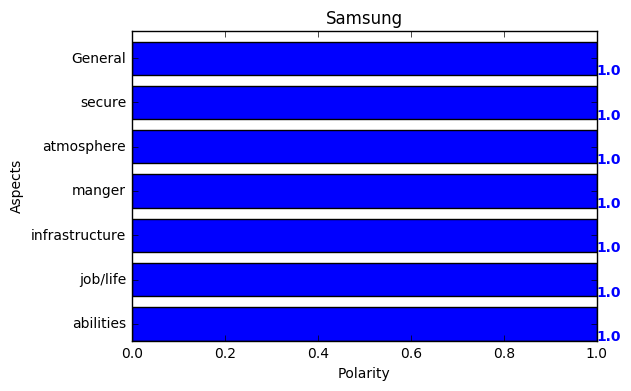

Overall Polarity  [ 1.]


In [85]:
print 'Aspect Classifier = Lexical'
aspect_polarity5,aspect_count5=svc_unigram(dataset[1500:2500],'lexical')
#with open('aspect_polarity5','w') as f:
#    pickle.dump(aspect_polarity5,f) 
#with open('aspect_count5','w') as f:
#    pickle.dump(aspect_count5,f)
result(aspect_polarity5 , aspect_count5,'Samsung')